# Bayesian Analysis in R: NBA Final 2-Minutes - Poisson Regression
---
Recently, my brother and I have been arguing about random chance in sports, specifically orienting around sports betting. His argument is certainly reasonable, as he believes too much random chance is involved in sport events to predict games with consistency. As a data science & machine learning enthusiast, I would love to prove this notion wrong. 

For this project, I will be attempting to create win probability generator by projecting the estimated amount of points a team will score based on the time left and other in-game statistics. We will use differential statistics to help provide relative performance and develop a few ways to track in game momentum. In my course for UC Santa Cruz for Bayesian statistics, we have explored creating Poisson regression in hierachal models. We will use this educational experience to help develop a model which can consistently project outcomes of games.

## Data and Functions used
---
The data is found on kaggle here: [2019-2020 NBA Play-by-play Dataset](https://www.kaggle.com/datasets/harrywang/nba-play-by-play-2019-2020-season). Fortunately, I used this dataset for a Tableau visualization project so I have already got a good set of clean data. Below are the functions which were used to perform the cleaning if you have interest in replicating. This has all of your basic stats aggregated, which will be the variables the focus of this project. Feel free to use the functions/data for other uses as well!

In [ ]:
import pandas as pd
import time
import re

def gameResultDataFrames(df):
    """
    Enables us to see the 
    Input: 
    -- df: With play-by-play data from the 2019-2020 data

    Output:
    Creating two dataframes
    - regResults_df: Regular Season aggregated statistics
    - playoffResults_df: Playoffs aggregated statistics
    
    """

    columns = [
        "GameType", "Date", "WinningTeam", "AwayTeam", "HomeTeam",
        "ShotOutcome", "ShotDist", "Assister", "Blocker", "FoulType", 
        "ReboundType", "FreeThrowOutcome", "TurnoverPlayer", "PointsAttempted", "PointsMade"
    ]
    df = df[columns]
    df["OffensiveRebound"] = df["ReboundType"].apply(lambda x: 1 if x == "offensive" else 0)
    df["DefensiveRebound"] = df["ReboundType"].apply(lambda x: 1 if x == "defensive" else 0)

    regResults_df = df[df['GameType'] != 'playoff']
    playoffResults_df = df[df['GameType'] == 'playoff']

    agg_functions = {
        'WinningTeam': 'first',
        'ShotDist': 'mean',      
        'Assister': 'count',     
        'Blocker': 'count',      
        'FoulType': 'count',                     
        'ReboundType': 'count',
        'OffensiveRebound': 'sum',
        'DefensiveRebound': 'sum',
        'FreeThrowOutcome': 'count',
        'TurnoverPlayer': 'count',
        'PointsAttempted': 'sum',
        'PointsMade': 'sum'    
    }

    # Group by Date, HomeTeam, and AwayTeam and aggregate the stats
    regResults_df = regResults_df.groupby(['Date', 'HomeTeam', 'AwayTeam']).agg(agg_functions).reset_index()
    playoffResults_df = playoffResults_df.groupby(['Date', 'HomeTeam', 'AwayTeam']).agg(agg_functions).reset_index()

    return regResults_df, playoffResults_df


def losingTeam(row):
    """
    Determine losing team... simple as
    """
    if row["HomeTeam"] != row["WinningTeam"]:
        return row["HomeTeam"]
    elif row["AwayTeam"] != row["WinningTeam"]:
        return row["AwayTeam"]


def gameCount(df):
    """
    Returns the amount of games each team has played to this point in the season
    """
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date').reset_index(drop=True)
    
    df['HomeTeamTotalGames'] = 0
    df['AwayTeamTotalGames'] = 0
    
    game_counts = {}
    
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        
        if home_team not in game_counts:
            game_counts[home_team] = 0
        if away_team not in game_counts:
            game_counts[away_team] = 0
        
        game_counts[home_team] += 1
        game_counts[away_team] += 1
        
        df.loc[index, 'HomeTeamTotalGames'] = game_counts[home_team]
        df.loc[index, 'AwayTeamTotalGames'] = game_counts[away_team]
    
    return df

def mergeGameNumber(pbp_df,regResults_df,playoffResults_df):
    """
    Merges the game number to the pbp_df from the Results dataframes
    Inputs:
    -- pbp_df: Play-by-play data which will be the receiver of the merge
    -- regResults_df,playoffResults_df: Data which contains game number

    Output:
    -- pbp_df: Play-by-play data with unique game numbers
    """
    results_df = pd.concat([regResults_df,playoffResults_df],ignore_index=True)

    pbp_df['Date'] = pd.to_datetime(pbp_df['Date'])
    results_df['Date'] = pd.to_datetime(results_df['Date'])
    
    pbp_df = pd.merge(pbp_df, results_df[['Date', 'HomeTeam', 'AwayTeam', 'HomeTeamTotalGames', 'AwayTeamTotalGames']], 
                         on=['Date', 'HomeTeam', 'AwayTeam'], 
                         how='left')

    return pbp_df
    
def determineCurrentTeam(gameType:str, playerCode: str, homeTeam: str, awayTeam: str, bRef: pd.DataFrame):
    """
    Determines the current team of a player based on the game information and player team data. Basketball reference data is used to verify
    the teams played for

    Inputs:
    -- gameType: Playoff or Regular season game
         If its a playoff team, clearly they would be on last team traded to
    -- playerCode: Player code for identification between basketball reference data and the pbp data
    -- homeTeam, awayTeam: Options for a player to be on
    -- bRef: Data from basketball reference to validate what team each player could play for

    Output:
    -- Inside a column which this is applied to, this will return the team of each player, with players who played for both being labelled with both
    seperated by a slash to be rectified later with `resolvePlayerMovement`
    """
    if pd.isna(playerCode):
        return np.nan
    elif playerCode == "Team":
        return "Team"
    player_teams = bRef.loc[bRef['PlayerCode'] == playerCode, 'Tm'].unique()
    if len(player_teams) == 0:
        # player who did not player in the regular season but was picked up for the playoff
        if playerCode == "adamsja01":
            return "POR"
        return "Coach"
    
    if len(player_teams) == 1:
        return player_teams[0] if player_teams[0] in [homeTeam, awayTeam] else fr"{homeTeam}/{awayTeam}"
    elif len(player_teams) == 3:
        if gameType == "playoff":
            return player_teams[2]
        # checking the teams
        if homeTeam == player_teams[1] and awayTeam != player_teams[2]:
            return homeTeam
        elif awayTeam == player_teams[1] and homeTeam != player_teams[2]:
            return awayTeam
        if homeTeam in player_teams and awayTeam in player_teams:
            return f"{homeTeam}/{awayTeam}"
    else:
        if gameType == "playoff":
            return player_teams[-1]
        # checking the teams
        if homeTeam in player_teams and awayTeam not in player_teams:
            return homeTeam
        elif awayTeam in player_teams and homeTeam not in player_teams:
            return awayTeam
        if homeTeam in player_teams and awayTeam in player_teams:
            return f"{homeTeam}/{awayTeam}"
    return fr"{homeTeam}/{awayTeam}"

def handlePlayerCode(df: pd.DataFrame, col: str, bRef: pd.DataFrame): 
    """
    Seperates playercode and player so we can then apply the `determineCurrentTeam` function

    Input:
    -- df: Dataframe with play-by-play data whose player name and player codes are stored as single value
    -- col: Column we want to extract perform the split on
    -- bRef: For the `determineCurrentTeam` function's use
    """
    def extractCode(x):
        try:
            if pd.notna(x):
                player, code = x.split(" - ")
                player = player.strip()
                code = code.strip()
                return player, code
            else:
                return np.nan,np.nan
        except Exception as e:
            if x == "Team":
                return "Team", "Team"
            # these are causing problems, need to explore
            print(f"Could not split: {x}")
            return "UTD","UTD"

    df[col], df[f"{col}PCode"] = zip(*df[col].apply(extractCode))
    
    df[f"{col}Team"] = df.apply(lambda row: determineCurrentTeam(
        row["GameType"],
        row[f"{col}PCode"],
        row["HomeTeam"],
        row["AwayTeam"],
        bRef
    ), axis=1)

    return df

One thing that happens every NBA season is that we have trades. Unfortunately, at the time I created these functions. I was unable to get the proper game number for each player, so I manually adjusted them using basketball reference to verify the correct game number to rectify trades for a few of the players. I would be open to suggestions on how I could rectify this issue for any reviewers. How I handled it originally is at the bottom:

In [ ]:
def playersTeamInfoDF(df: pd.DataFrame):
    """
    -- Creates a unique entry of everytime a player enters a game in the play-by-play dataframe enabling us to set a point where they first
    played and appropriately assign the proper team with `resolveTrades` which will be built after

    Output:
    - df: DataFrame with the unique information on players, their teams, and their first appearance with that team
    -- Works for certain players, but needs to be manually validated for accurate game number of first appearance
    
    """
    df = df[['Date','HomeTeam','AwayTeam','EnterGame','EnterGamePCode','EnterGameTeam','HomeTeamTotalGames','AwayTeamTotalGames']]
    df = df.drop_duplicates(subset=["EnterGame","EnterGameTeam"],keep="first")
    df = df.dropna(subset=["EnterGameTeam"])
    df = df.groupby(['Date','HomeTeam','AwayTeam','EnterGame']).first().reset_index()
    df = df[~df['EnterGameTeam'].str.contains("/", na=False)]
    def gamesNo(row):
        if row['AwayTeam'] == row['EnterGameTeam']:
            return row["AwayTeamTotalGames"]
        return row["HomeTeamTotalGames"]

    df["FirstPlayedInTeamGameNo"] = df.apply(gamesNo,axis=1)
    columns_to_drop = ['Date', 'HomeTeam', 'AwayTeam', 'HomeTeamTotalGames', 'AwayTeamTotalGames']
    df.drop(columns=columns_to_drop, inplace=True)
        
    df = df.rename(columns={"EnterGame":"Player",
                             "EnterGameTeam":"Team",
                             "EnterGamePCode":"PlayerCode"})

    return df

def resolvePlayerMovement(pcode:str, homeTeam:str, awayTeam:str, homeTeamGno:int, awayTeamGno:int, playerMovementInfo: pd.DataFrame):
    """
    Based on the player's first appearance with the team, this will now resolve the player movement across the league. Should be used with `.apply` method
    Inputs:
    -- pcode: Player code for identification
    -- homeTeam, awayTeam: Home & Away Team for comparison of players teams during the 2019-20 season
    -- homeTeamGno, awayTeamGno: Home & Away Team's Game number for reference
    -- playerMovementInfo: Validated dataframe which has proper game numbers of players first appearances with multiple teams

    Output:
    -- In the column it is being applied to, `{col}Team`, will now accurately reflect players team information
    
    """
    teamsPlayedFor = playerMovementInfo.loc[playerMovementInfo["PlayerCode"] == pcode]

    if len(teamsPlayedFor) == 1:
        return teamsPlayedFor.iloc[0]["Team"]
    if len(teamsPlayedFor) > 1:
        teamRecords = {row['Team']: row for index, row in teamsPlayedFor.iterrows()}

        if homeTeam in teamRecords and awayTeam not in teamRecords:
            return homeTeam
        elif awayTeam in teamRecords and homeTeam not in teamRecords:
            return awayTeam
        elif homeTeam in teamRecords and awayTeam in teamRecords:
            if teamRecords[homeTeam]['FirstPlayedInTeamGameNo'] <= homeTeamGno and teamRecords[awayTeam]['FirstPlayedInTeamGameNo'] > awayTeamGno:
                return homeTeam
            elif teamRecords[awayTeam]['FirstPlayedInTeamGameNo'] <= awayTeamGno and teamRecords[homeTeam]['FirstPlayedInTeamGameNo'] > homeTeamGno:
                return awayTeam

def applyPlayerMovement(df: pd.DataFrame, playerMovementInfo: pd.DataFrame):
    """
    Just a loop for `resolvePlayerMovement`
    """
    columns = [
        "Shooter",
        "Assister",
        "Blocker",
        "Fouler",
        "Fouled",
        "Rebounder",
        "ViolationPlayer",
        "FreeThrowShooter",
        "EnterGame",
        "LeaveGame",
        "TurnoverPlayer",
        "TurnoverCauser",
        "JumpballAwayPlayer",
        "JumpballHomePlayer",
        "JumpballPoss",
    ]
    for col in columns:
        df[f"{col}Team"] = df.apply(lambda row: resolvePlayerMovement(row[f"{str(col)}PCode"],
                                                               row["HomeTeam"],
                                                               row["AwayTeam"],
                                                               row["HomeTeamTotalGames"],
                                                               row["AwayTeamTotalGames"],
                                                               playerMovementInfo),axis=1)
    return df

# tradedPlayerInfo = playersTeamInfoDF(pbp_df)
# tradedPlayerInfo = tradedPlayerInfo.sort_values(by="Player").reset_index()
# tradedPlayerInfo.drop('index',axis=1,inplace=True)
# tradedPlayerInfo.to_csv("TradeInfo.csv", index=False)
# ## Execute above first, correct any incorrect values for game numbers, then execute below seperately after
# playerMovementInfo = pd.read_csv(r"C:/users/jeffg/Downloads/NBA Analysis/TradeInfo.csv")
# traded_df = applyPlayerMovement(pbp_df,playerMovementInfo)

Rest is done without manual intervention.

In [ ]:
def gameScore(df: pd.DataFrame):
    """
    Returns the running gamescore up til that point in the game

    Inputs:
    -- df: play-by-play data processed

    Outputs
    *Inside of the returned df
    -- Home/AwayGameScore: running totals of game score for distinct game
    """
    df["HomeGameScore"] = 0
    df["AwayGameScore"] = 0

    grouped = df.groupby(['Date', 'HomeTeam', 'AwayTeam'])

    for (date, homeTeam, awayTeam), group in grouped:
        homeStats = 0
        awayStats = 0

        # Iterating through each row within the group and updating running totals
        for i, row in group.iterrows():
            if row["ShooterTeam"] == homeTeam or row["FreeThrowShooterTeam"] == homeTeam:
                homeStats += row["PointsMade"]
            elif row["ShooterTeam"] == awayTeam or row["FreeThrowShooterTeam"] == awayTeam:
                awayStats += row["PointsMade"]
            df.at[i, "HomeGameScore"] = homeStats
            df.at[i, "AwayGameScore"] = awayStats

    # Converting the new columns to uint8 type to save memory
    df["HomeGameScore"] = df["HomeGameScore"].astype(np.uint8)
    df["AwayGameScore"] = df["AwayGameScore"].astype(np.uint8)

    return df

def CurrentFGpercent(df: pd.DataFrame):
    """
    Returns the team's current FG% to that point in the game
    Inputs:
    -- Dataframe: Needs to contain play by play data with the following columns
        - Date
        - HomeTeam
        - AwayTeam
        - ShotOutcome
        - ShooterTeam

    Outputs:
    *Inside of the returned df
    -- HomeFG, AwayFG: To that point in time ingame, team's game FG%
    """
    df["HomeFG"] = 0
    df["AwayFG"] = 0

    grouped = df.groupby(['Date', 'HomeTeam', 'AwayTeam'])

    for (date, homeTeam, awayTeam), group in grouped:
        homeMakes = 0
        awayMakes = 0
        homeMisses = 0
        awayMisses = 0

        # updating running totals for each game for each play
        for i, row in group.iterrows():
            if row["ShotOutcome"] == "make" and row["ShooterTeam"] == homeTeam:
                homeMakes += 1
            elif row["ShotOutcome"] == "make" and row["ShooterTeam"] == awayTeam:
                awayMakes += 1
            elif row["ShotOutcome"] == "miss" and row["ShooterTeam"] == homeTeam:
                homeMisses += 1
            elif row["ShotOutcome"] == "miss" and row["ShooterTeam"] == awayTeam:
                awayMisses += 1
            try: 
                homeFg = homeMakes/(homeMakes+homeMisses)
            except ZeroDivisionError:
                homeFg = 0.000
            try:
                awayFg = awayMakes/(awayMakes+awayMisses)
            except ZeroDivisionError:
                awayFg = 0.000

            # updates each row at record level
            df.at[i, f"HomeFG"] = homeFg
            df.at[i, f"AwayFG"] = awayFg

    # uint8 type to save memory
    # was more of an issue when NN was the goal, but still best to optimize for memory
    df["HomeFG"] = df["HomeFG"].astype(np.float32)
    df["AwayFG"] = df["AwayFG"].astype(np.float32)

    return df

def Current3FGpercent(df: pd.DataFrame):
    """
    Returns the team's current FG% to that point in the game
    Inputs:
    -- Dataframe: Needs to contain play by play data with the following columns
        - Date
        - HomeTeam
        - AwayTeam
        - ShotOutcome
        - ShotType
        - ShooterTeam

    Outputs:
    *Inside of the returned df
    -- HomeFG, AwayFG: To that point in time ingame, team's game 3FG%
    """
    df["Home3FG"] = 0
    df["Away3FG"] = 0

    grouped = df.groupby(['Date', 'HomeTeam', 'AwayTeam'])

    for (date, homeTeam, awayTeam), group in grouped:
        home3Makes = 0
        away3Makes = 0
        home3Misses = 0
        away3Misses = 0

        # updating running totals for each game for each play
        for i, row in group.iterrows():
            if row["ShotOutcome"] == "make" and row["ShotType"] == "3-pt jump shot" and row["ShooterTeam"] == homeTeam:
                home3Makes += 1
            elif row["ShotOutcome"] == "make" and row["ShotType"] == "3-pt jump shot" and row["ShooterTeam"] == awayTeam:
                away3Makes += 1
            elif row["ShotOutcome"] == "miss" and row["ShotType"] == "3-pt jump shot" and row["ShooterTeam"] == homeTeam:
                home3Misses += 1
            elif row["ShotOutcome"] == "miss" and row["ShotType"] == "3-pt jump shot" and row["ShooterTeam"] == awayTeam:
                away3Misses += 1

            try:
                home3Fg = home3Makes/(home3Makes+home3Misses)
            except:
                home3Fg = 0.000

            try:
                away3Fg = away3Makes/(away3Makes+away3Misses)
            except:
                away3Fg = 0.000

            # updates each row at record level
            df.at[i, f"Home3FG"] = home3Fg
            df.at[i, f"Away3FG"] = away3Fg

    # save memory
    df["Home3FG"] = df["Home3FG"].astype(np.float32)
    df["Away3FG"] = df["Away3FG"].astype(np.float32)

    return df

def totalSteals(df:pd.DataFrame):
    """
    This looks at the turnover cause and if it is a steal, this returns a running total by game

    input:
    -- df: play-by-play nba data
    output:
    *Inside of the returned df
    -- HomeStealsTotal, AwayStealsTotal: Running total by play of each team's steal total
    """
    df["HomeSteals"] = 0
    df["AwaySteals"] = 0

    grouped = df.groupby(['Date','HomeTeam','AwayTeam'])

    # distinct games
    for (date, homeTeam, awayTeam), group in grouped:
        homeSteals = 0
        awaySteals = 0

        # running totals
        for i, row in group.iterrows():
            if row["TurnoverCause"] == "steal" and row["TurnoverCauserTeam"] == homeTeam:
                homeSteals += 1
            elif row["TurnoverCause"] == "steal" and row["TurnoverCauserTeam"] == awayTeam:
                awaySteals += 1
            df.at[i, "HomeSteals"] = homeSteals
            df.at[i, "AwaySteals"] = awaySteals

    # uint8 to save memory
    df["HomeSteals"] = df["HomeSteals"].astype(np.uint8)
    df["AwaySteals"] = df["AwaySteals"].astype(np.uint8)

    return df

def totalStats(df: pd.DataFrame, col: str):
    """
    Totals the traditional metrics such as rebounds and assists

    input:
    -- df: contains play-by-play nba data
    -- col: column you want to aggregate totals for

    output:
    *Inside of the returned df
    -- Home{col}, Away{col}
    """
    df[f"Home{col}"] = 0
    df[f"Away{col}"] = 0

    grouped = df.groupby(['Date', 'HomeTeam', 'AwayTeam'])

    # distinct games
    for (date, homeTeam, awayTeam), group in grouped:
        homeStats = 0
        awayStats = 0

        # updating running totals
        for i, row in group.iterrows():
            if row[f"{col}Team"] == homeTeam:
                homeStats += 1
            elif row[f"{col}Team"] == awayTeam:
                awayStats += 1
            df.at[i, f"Home{col}"] = homeStats
            df.at[i, f"Away{col}"] = awayStats

    # uint8 type to save memory
    df[f"Home{col}"] = df[f"Home{col}"].astype(np.uint8)
    df[f"Away{col}"] = df[f"Away{col}"].astype(np.uint8)

    return df

def OffDefRebSplit(df:pd.DataFrame):
    """
    Divides the rebounds into offensive and defensive totals
    Inputs:
    -- df: contains play-by-play data which has had total stats aggregated so far
    Outputs:
    *Inside of the returned df for both home and away
    -- OffRebTotal, DefRebTotal: Split of offensive and defensive rebounds for a team
    """
    df["HomeDReb"] = 0
    df["HomeOReb"] = 0
    df["AwayDReb"] = 0
    df["AwayOReb"] = 0

    grouped = df.groupby(['Date', 'HomeTeam', 'AwayTeam'])

    # distinct games
    for (date, homeTeam, awayTeam), group in grouped:
        homeDReb = 0
        homeOReb = 0
        awayDreb = 0
        awayOreb = 0

        # updating running totals for each game for each play
        for i, row in group.iterrows():
            if row["RebounderTeam"] == homeTeam and row["ReboundType"] == "defensive":
                homeDReb += 1
            elif row["RebounderTeam"] == homeTeam and row["ReboundType"] == "offensive":
                homeOReb += 1
            if row["RebounderTeam"] == awayTeam and row["ReboundType"] == "defensive":
                awayDreb += 1
            elif row["RebounderTeam"] == awayTeam and row["ReboundType"] == "offensive":
                awayOreb += 1
            # updates each row at record level
            df.at[i, "HomeDReb"] = homeDReb
            df.at[i, "HomeOReb"] = homeOReb
            df.at[i, "AwayDReb"] = awayDreb
            df.at[i, "AwayOReb"] = awayOreb

    # uint8 type to save memory
    # was more of an issue when NN was the goal, but still best to optimize for memory
    df["HomeDReb"] = df["HomeDReb"].astype(np.uint8)
    df["HomeOReb"] = df["HomeOReb"].astype(np.uint8)
    df["AwayDReb"] = df["AwayDReb"].astype(np.uint8)
    df["AwayOReb"] = df["AwayOReb"].astype(np.uint8)

    return df

def renameStatCols(df: pd.DataFrame):
    """
    Renames the columns created which have awkward naming conventions due to using the `col` in `totalStats` function

    More of a preferential one, but makes it easier to understand to human eye
    """
    columnsSwitch = {
        "Assister": "Assists",
        "Blocker": "Blocks",
        "Fouler": "Fouls",
        "Rebounder": "Rebounds",
        "ViolationPlayer": "Violations",
        "FreeThrowShooter": "FreeThrows",
        "TurnoverPlayer": "Turnovers",
        "TurnoverCauser": "TurnoversForced"
    }
    for oldCol, newCol in columnsSwitch.items():
        df.rename(columns={f'Home{oldCol}': f'Home{newCol}', f'Away{oldCol}': f'Away{newCol}'}, inplace=True)

    return df

The above code should be executed sequentially as presented, with the trade data functions being the only break for manual inspection. We will be shortening this to the final 5 minutes of games to create the win probabilties, which will also be in the repo. If you want the full dataset, just download the data from kaggle and execute the functions.

## NBA Win Projections
-----
The NBA and partners of the NBA use various statistical techniques to create win probabilities. Two of the most popular are neural networks and Bayesian techniques. I have plans to do a RNN in the future, but my current laptop is low GPU power and I am in midst of acquiring the parts to build a fine running machine learning *mean machine*. Since we will be working with count data, a Bayesian approach to a poisson regression with Monte Carlo Markov Chain simulated parameters should create an accurate win probability generator with an interpretable inference.

We will limit the data to the final 5 minutes of presumed final quarter, the 4th quarter. Overtime can often shift things due to a break in action and momentum, so we would probably want to model that additional factor differently. Before we do this, we will create a few additional features relating to scoring in a time interval and track the differential of the hometeam's stats. Let's take an initial look at the data!

In [1]:
import os
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

path = str(os.getenv('DOWNLOADS'))
path += "/NBA Analysis/Checkpoint.csv"

pbp_df = pd.read_csv(path)

pd.set_option('display.max_columns',None)
pbp_df.head()

,GameType,Date,WinningTeam,Quarter,SecLeft,AwayTeam,HomeTeam,Shooter,ShotType,ShotOutcome,ShotDist,Assister,Blocker,FoulType,Fouler,Fouled,Rebounder,ReboundType,ViolationPlayer,ViolationType,TimeoutTeam,FreeThrowShooter,FreeThrowOutcome,FreeThrowNum,EnterGame,LeaveGame,TurnoverPlayer,TurnoverType,TurnoverCause,TurnoverCauser,JumpballAwayPlayer,JumpballHomePlayer,JumpballPoss,PointsAttempted,PointsMade,LosingTeam,HomeTeamTotalGames,AwayTeamTotalGames,ShooterPCode,ShooterTeam,AssisterPCode,AssisterTeam,BlockerPCode,BlockerTeam,FoulerPCode,FoulerTeam,FouledPCode,FouledTeam,RebounderPCode,RebounderTeam,ViolationPlayerPCode,ViolationPlayerTeam,FreeThrowShooterPCode,FreeThrowShooterTeam,EnterGamePCode,EnterGameTeam,LeaveGamePCode,LeaveGameTeam,TurnoverPlayerPCode,TurnoverPlayerTeam,TurnoverCauserPCode,TurnoverCauserTeam,JumpballAwayPlayerPCode,JumpballAwayPlayerTeam,JumpballHomePlayerPCode,JumpballHomePlayerTeam,JumpballPossPCode,JumpballPossTeam,HomeGameScore,AwayGameScore,HomeFG,AwayFG,HomeDReb,HomeOReb,AwayDReb,AwayOReb,Home3FG,Away3FG,HomeSteals,AwaySteals,HomeAssists,AwayAssists,HomeBlocks,AwayBlocks,HomeFouls,AwayFouls,HomeRebounds,AwayRebounds,HomeViolations,AwayViolations,HomeFreeThrows,AwayFreeThrows,HomeTurnovers,AwayTurnovers,HomeTurnoversForced,AwayTurnoversForced
0,regular,2019-10-22,TOR,1,720,NOP,TOR,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D. Favors,M. Gasol,L. Ball,0,0,NOP,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,favorde01,NOP,gasolma01,TOR,balllo01,NOP,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,regular,2019-10-22,TOR,1,708,NOP,TOR,L. Ball,2-pt jump shot,miss,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,NOP,1,1,balllo01,NOP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,regular,2019-10-22,TOR,1,707,NOP,TOR,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,D. Favors,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NOP,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,favorde01,NOP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0,0,0,1,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,regular,2019-10-22,TOR,1,707,NOP,TOR,D. Favors,2-pt layup,make,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NOP,1,1,favorde01,NOP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0.0,0.5,0,0,0,1,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,regular,2019-10-22,TOR,1,689,NOP,TOR,O. Anunoby,2-pt layup,miss,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,NOP,1,1,anunoog01,TOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0.0,0.5,0,0,0,1,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [2]:
pd.set_option('display.max_rows',None)
pbp_df.dtypes

GameType                    object
Date                        object
WinningTeam                 object
Quarter                      int64
SecLeft                      int64
AwayTeam                    object
HomeTeam                    object
Shooter                     object
ShotType                    object
ShotOutcome                 object
ShotDist                     int64
Assister                    object
Blocker                     object
FoulType                    object
Fouler                      object
Fouled                      object
Rebounder                   object
ReboundType                 object
ViolationPlayer             object
ViolationType               object
TimeoutTeam                 object
FreeThrowShooter            object
FreeThrowOutcome            object
FreeThrowNum                object
EnterGame                   object
LeaveGame                   object
TurnoverPlayer              object
TurnoverType                object
TurnoverCause       

In [19]:
pbp_df.describe()

,Quarter,SecLeft,ShotDist,PointsAttempted,PointsMade,HomeTeamTotalGames,AwayTeamTotalGames,HomeGameScore,AwayGameScore,HomeFG,AwayFG,HomeDReb,HomeOReb,AwayDReb,AwayOReb,Home3FG,Away3FG,HomeSteals,AwaySteals,HomeAssists,AwayAssists,HomeBlocks,AwayBlocks,HomeFouls,AwayFouls,HomeRebounds,AwayRebounds,HomeViolations,AwayViolations,HomeFreeThrows,AwayFreeThrows,HomeTurnovers,AwayTurnovers,HomeTurnoversForced,AwayTurnoversForced
count,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000,539265.000000
mean,2.545066,331.896518,5.273164,0.994146,0.473276,33.771344,33.778508,57.748354,56.538583,0.467075,0.454439,18.363103,5.130318,17.814525,4.923131,0.357160,0.347074,3.849371,3.997591,13.086494,12.513466,2.564340,2.431602,10.162838,10.366942,23.493422,22.737656,0.001422,0.002014,10.806930,10.572288,7.165796,7.117853,3.849371,3.997591
std,1.137296,207.613650,9.513159,1.156538,0.895900,21.235383,21.221005,33.676149,33.172562,0.120003,0.114705,10.725700,3.862929,10.592795,3.748537,0.172656,0.167201,2.933832,3.032442,7.895170,7.688924,2.283276,2.175326,6.860610,6.974224,13.778919,13.472265,0.037687,0.046536,8.341136,8.083049,4.897836,4.906951,2.933832,3.032442
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,153.000000,0.000000,0.000000,0.000000,14.000000,15.000000,29.000000,28.000000,0.410526,0.400000,9.000000,2.000000,9.000000,2.000000,0.266667,0.260870,1.000000,2.000000,7.000000,6.000000,1.000000,1.000000,4.000000,4.000000,12.000000,11.000000,0.000000,0.000000,4.000000,4.000000,3.000000,3.000000,1.000000,2.000000
50%,3.000000,326.000000,0.000000,0.000000,0.000000,33.000000,33.000000,57.000000,56.000000,0.467532,0.457143,18.000000,5.000000,17.000000,4.000000,0.357143,0.347826,3.000000,4.000000,13.000000,12.000000,2.000000,2.000000,10.000000,10.000000,23.000000,22.000000,0.000000,0.000000,10.000000,9.000000,7.000000,7.000000,3.000000,4.000000
75%,4.000000,508.000000,5.000000,2.000000,0.000000,52.000000,52.000000,85.000000,84.000000,0.523810,0.508475,27.000000,8.000000,26.000000,7.000000,0.444444,0.433333,6.000000,6.000000,19.000000,18.000000,4.000000,4.000000,15.000000,15.000000,34.000000,33.000000,0.000000,0.000000,16.000000,16.000000,11.000000,10.000000,6.000000,6.000000
max,6.000000,720.000000,88.000000,3.000000,3.000000,75.000000,75.000000,158.000000,159.000000,1.000000,1.000000,55.000000,25.000000,52.000000,24.000000,1.000000,1.000000,18.000000,17.000000,43.000000,39.000000,20.000000,14.000000,39.000000,35.000000,67.000000,65.000000,1.000000,2.000000,52.000000,50.000000,28.000000,28.000000,18.000000,17.000000


In [3]:
print(f"We have {len(pbp_df[(pbp_df['Quarter'] == 4) & (pbp_df['SecLeft'] <= 300)])} sample records for Bayesian Analysis!")

We have 63945 sample records for Bayesian Analysis!


I want to two more features for scoring to cover some aspect of the game's momentum. Points scored in previous 2 minutes and points scored in previous 5 minutes. This should help add data to cover this aspect of the game's current flow. So we will first limit the data to the final 10 minutes and 4th quarter so we are able to capture the momentum going into the final 5 minutes as well.

In [4]:
filtered_df = pbp_df[(pbp_df['Quarter'] == 4) & (pbp_df['SecLeft'] <= 600)]
def scoringInterval(df,second_interval:int==120):
    """
    Creates a running total of points in the specified seconds intervals
    - Helps capture the momentum of the game
    - Needs to be performed on data for a specific quarter

    Inputs:
    -- df: dataframe with play-by-play data
    -- second_interval: running total window
    Outputs:
    -- df: DataFrame with new running total columns in Home/Away `PointsScoredLast{x}Seconds`
    """
    df[f"HomePointsScoredLast{second_interval}Seconds"] = 0
    df[f"AwayPointsScoredLast{second_interval}Seconds"] = 0

    for i, row in df.iterrows():
        # establish bounds of intervals
        intv_start = row["SecLeft"]
        intv_end = intv_start + second_interval
        # print(f"Row {i}: intv_start={intv_start}, intv_end={intv_end}") # debugging
        # create interval window
        window = df[
            (df["HomeTeam"] == row["HomeTeam"]) &
            (df["AwayTeam"] == row["AwayTeam"]) &
            (df["Date"] == row["Date"]) &
            (df["SecLeft"] >= intv_start) &
            (df["SecLeft"] < intv_end)
        ]
        # modify the window if there is sufficient data to do so
        if len(window) > 1:
            home_points = window["HomeGameScore"].iloc[-1] - window["HomeGameScore"].iloc[0]
            away_points = window["AwayGameScore"].iloc[-1] - window["AwayGameScore"].iloc[0]
            df.loc[i, f"HomePointsScoredLast{second_interval}Seconds"] = home_points
            df.loc[i, f"AwayPointsScoredLast{second_interval}Seconds"] = away_points
            # print(f"Home Points: {home_points}, Away Points: {away_points}") # debugging
    return df

running_5min = scoringInterval(filtered_df,300)
running_2min = scoringInterval(running_5min,120)

fivemin_df = running_2min[(running_2min['Quarter'] == 4) & (running_2min['SecLeft'] <= 300)]

In [5]:
fivemin_df.head()

,GameType,Date,WinningTeam,Quarter,SecLeft,AwayTeam,HomeTeam,Shooter,ShotType,ShotOutcome,ShotDist,Assister,Blocker,FoulType,Fouler,Fouled,Rebounder,ReboundType,ViolationPlayer,ViolationType,TimeoutTeam,FreeThrowShooter,FreeThrowOutcome,FreeThrowNum,EnterGame,LeaveGame,TurnoverPlayer,TurnoverType,TurnoverCause,TurnoverCauser,JumpballAwayPlayer,JumpballHomePlayer,JumpballPoss,PointsAttempted,PointsMade,LosingTeam,HomeTeamTotalGames,AwayTeamTotalGames,ShooterPCode,ShooterTeam,AssisterPCode,AssisterTeam,BlockerPCode,BlockerTeam,FoulerPCode,FoulerTeam,FouledPCode,FouledTeam,RebounderPCode,RebounderTeam,ViolationPlayerPCode,ViolationPlayerTeam,FreeThrowShooterPCode,FreeThrowShooterTeam,EnterGamePCode,EnterGameTeam,LeaveGamePCode,LeaveGameTeam,TurnoverPlayerPCode,TurnoverPlayerTeam,TurnoverCauserPCode,TurnoverCauserTeam,JumpballAwayPlayerPCode,JumpballAwayPlayerTeam,JumpballHomePlayerPCode,JumpballHomePlayerTeam,JumpballPossPCode,JumpballPossTeam,HomeGameScore,AwayGameScore,HomeFG,AwayFG,HomeDReb,HomeOReb,AwayDReb,AwayOReb,Home3FG,Away3FG,HomeSteals,AwaySteals,HomeAssists,AwayAssists,HomeBlocks,AwayBlocks,HomeFouls,AwayFouls,HomeRebounds,AwayRebounds,HomeViolations,AwayViolations,HomeFreeThrows,AwayFreeThrows,HomeTurnovers,AwayTurnovers,HomeTurnoversForced,AwayTurnoversForced,HomePointsScoredLast300Seconds,AwayPointsScoredLast300Seconds,HomePointsScoredLast120Seconds,AwayPointsScoredLast120Seconds
458,regular,2019-10-22,TOR,4,299,NOP,TOR,P. Siakam,2-pt layup,miss,3,NaN,J. Okafor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,NOP,1,1,siakapa01,TOR,NaN,NaN,okafoja01,NOP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,106,0.397727,0.435294,32,14,32,14,0.354839,0.432432,6,4,17,26,2,8,21,26,46,46,0,0,27,18,13,16,6,4,12,13,3,7
459,regular,2019-10-22,TOR,4,298,NOP,TOR,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,P. Siakam,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NOP,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,siakapa01,TOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,106,0.397727,0.435294,32,15,32,14,0.354839,0.432432,6,4,17,26,2,8,21,26,47,46,0,0,27,18,13,16,6,4,12,13,3,7
460,regular,2019-10-22,TOR,4,298,NOP,TOR,P. Siakam,2-pt layup,miss,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,NOP,1,1,siakapa01,TOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,106,0.393258,0.435294,32,15,32,14,0.354839,0.432432,6,4,17,26,2,8,21,26,47,46,0,0,27,18,13,16,6,4,12,13,3,7
461,regular,2019-10-22,TOR,4,298,NOP,TOR,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,P. Siakam,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NOP,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,siakapa01,TOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,106,0.393258,0.435294,32,16,32,14,0.354839,0.432432,6,4,17,26,2,8,21,26,48,46,0,0,27,18,13,16,6,4,12,13,3,7
462,regular,2019-10-22,TOR,4,298,NOP,TOR,NaN,NaN,NaN,0,NaN,NaN,personal,B. Ingram,P. Siakam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NOP,1,1,NaN,NaN,NaN,NaN,NaN,NaN,ingrabr01,NOP,siakapa01,TOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,106,0.393258,0.435294,32,16,32,14,0.354839,0.432432,6,4,17,26,2,8,21,27,48,46,0,0,27,18,13,16,6,4,12,13,3,7


Since this will be put into one model, we will be using just the score to look at momentum. However, if we built an ensemble model, it might be useful to create a model to analyze the game/flow as well as possibly player performance to try to get a wholistic view of the game's current position. 

Next, instead of just using the raw totals, we will use the differential for the home team. This should help focus on the relative performance compared to the other team. 

In [6]:
fivemin_df["HomePointDifferential"] = fivemin_df["HomeGameScore"] - fivemin_df["AwayGameScore"]
fivemin_df["HomeFGDifferential"] = fivemin_df["HomeFG"] - fivemin_df["AwayFG"]
fivemin_df["HomeDRebDifferential"] = fivemin_df["HomeDReb"] - fivemin_df["AwayDReb"]
fivemin_df["HomeORebDifferential"] = fivemin_df["HomeOReb"] - fivemin_df["AwayOReb"]
fivemin_df["Home3FGDifferential"] = fivemin_df["Home3FG"] - fivemin_df["Away3FG"]
fivemin_df["HomeBlocksDifferential"] = fivemin_df["HomeBlocks"] - fivemin_df["AwayBlocks"]
fivemin_df["HomeStealsDifferential"] = fivemin_df["HomeSteals"] - fivemin_df["AwaySteals"]
fivemin_df["HomeAssistsDifferential"] = fivemin_df["HomeAssists"] - fivemin_df["AwayAssists"]
fivemin_df["HomeReboundsDifferential"] = fivemin_df["HomeRebounds"] - fivemin_df["AwayRebounds"]
fivemin_df["HomeFreeThrowDifferential"] = fivemin_df["HomeFreeThrows"] - fivemin_df["AwayFreeThrows"]
fivemin_df["HomeTurnoversDifferential"] = fivemin_df["HomeTurnovers"] - fivemin_df["AwayTurnovers"]
fivemin_df["HomeFoulsDifferential"] = fivemin_df["HomeFouls"] - fivemin_df["AwayFouls"]

This next function will assign an ID to 30 second intervals in the last 5 minutes. Once down to 1 minute, this will shrink to 15 second intervals, and finally down to 5 seconds until done. This allow us to create a lambda parameter based on the time interval so we can adjust the expectations of amount scored as time reduces.

In [7]:
def lambdaWindows(df):
    """
    Creates time windows to allow for random intercept model to adjust for decreasing time and point possibilities
    """
    # Define the window boundaries
    boundaries = [300, 270, 240, 210, 180, 150, 120, 90, 60, 45, 30, 15, 10, 5, 0]
    boundaries = sorted(boundaries, reverse=False) 

    # Assign window IDs using pd.cut
    df["LambdaWID"] = pd.cut(
        df["SecLeft"],
        bins=boundaries,
        labels=range(1, len(boundaries)), 
        right=False, 
    ).astype(int)

    return df

fivemin_df = lambdaWindows(fivemin_df)

Finally, we need our target variables: how many more points will be scored? We will need to create a running total of the *points remaining* to be scored.

In [14]:
def pointsRemaining(df):
    """
    Looks at the current time for the appropriate game and returns the remaining points scored in the game

    Inputs:
    -- df: Dataframe containing play-by-play data, with a date, home & away team to identify unique data

    Output:
    -- df: New columns of `PointsScoredRemaining_Home` and `PointsScoredRemaining_Home` now included
    """
    # group the games
    grouped = df.groupby(['HomeTeam', 'AwayTeam', 'Date'])
    # this will transform each row
    df['PointsScoredRemaining_Home'] = grouped['HomeGameScore'].transform(lambda x: x.iloc[-1] - x)
    df['PointsScoredRemaining_Away'] = grouped['AwayGameScore'].transform(lambda x: x.iloc[-1] - x)

    return df
    
final5_df = pointsRemaining(fivemin_df)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
final5_df["HomeTeam"] = le.fit_transform(final5_df["HomeTeam"])
final5_df["AwayTeam"] = le.fit_transform(final5_df["AwayTeam"])

In [15]:
final5_df.head()

,GameType,Date,WinningTeam,Quarter,SecLeft,AwayTeam,HomeTeam,Shooter,ShotType,ShotOutcome,ShotDist,Assister,Blocker,FoulType,Fouler,Fouled,Rebounder,ReboundType,ViolationPlayer,ViolationType,TimeoutTeam,FreeThrowShooter,FreeThrowOutcome,FreeThrowNum,EnterGame,LeaveGame,TurnoverPlayer,TurnoverType,TurnoverCause,TurnoverCauser,JumpballAwayPlayer,JumpballHomePlayer,JumpballPoss,PointsAttempted,PointsMade,LosingTeam,HomeTeamTotalGames,AwayTeamTotalGames,ShooterPCode,ShooterTeam,AssisterPCode,AssisterTeam,BlockerPCode,BlockerTeam,FoulerPCode,FoulerTeam,FouledPCode,FouledTeam,RebounderPCode,RebounderTeam,ViolationPlayerPCode,ViolationPlayerTeam,FreeThrowShooterPCode,FreeThrowShooterTeam,EnterGamePCode,EnterGameTeam,LeaveGamePCode,LeaveGameTeam,TurnoverPlayerPCode,TurnoverPlayerTeam,TurnoverCauserPCode,TurnoverCauserTeam,JumpballAwayPlayerPCode,JumpballAwayPlayerTeam,JumpballHomePlayerPCode,JumpballHomePlayerTeam,JumpballPossPCode,JumpballPossTeam,HomeGameScore,AwayGameScore,HomeFG,AwayFG,HomeDReb,HomeOReb,AwayDReb,AwayOReb,Home3FG,Away3FG,HomeSteals,AwaySteals,HomeAssists,AwayAssists,HomeBlocks,AwayBlocks,HomeFouls,AwayFouls,HomeRebounds,AwayRebounds,HomeViolations,AwayViolations,HomeFreeThrows,AwayFreeThrows,HomeTurnovers,AwayTurnovers,HomeTurnoversForced,AwayTurnoversForced,HomePointsScoredLast300Seconds,AwayPointsScoredLast300Seconds,HomePointsScoredLast120Seconds,AwayPointsScoredLast120Seconds,HomePointDifferential,HomeFGDifferential,HomeDRebDifferential,HomeORebDifferential,Home3FGDifferential,HomeBlocksDifferential,HomeStealsDifferential,HomeAssistsDifferential,HomeReboundsDifferential,HomeFreeThrowDifferential,HomeTurnoversDifferential,HomeFoulsDifferential,LambdaWID,PointsScoredRemaining_Home,PointsScoredRemaining_Away
458,regular,2019-10-22,TOR,4,299,18,27,P. Siakam,2-pt layup,miss,3,NaN,J. Okafor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,NOP,1,1,siakapa01,TOR,NaN,NaN,okafoja01,NOP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,106,0.397727,0.435294,32,14,32,14,0.354839,0.432432,6,4,17,26,2,8,21,26,46,46,0,0,27,18,13,16,6,4,12,13,3,7,-3,-0.037567,0,0,-0.077594,-6,2,-9,0,9,-3,-5,14,14,11
459,regular,2019-10-22,TOR,4,298,18,27,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,P. Siakam,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NOP,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,siakapa01,TOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,106,0.397727,0.435294,32,15,32,14,0.354839,0.432432,6,4,17,26,2,8,21,26,47,46,0,0,27,18,13,16,6,4,12,13,3,7,-3,-0.037567,0,1,-0.077594,-6,2,-9,1,9,-3,-5,14,14,11
460,regular,2019-10-22,TOR,4,298,18,27,P. Siakam,2-pt layup,miss,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,NOP,1,1,siakapa01,TOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,106,0.393258,0.435294,32,15,32,14,0.354839,0.432432,6,4,17,26,2,8,21,26,47,46,0,0,27,18,13,16,6,4,12,13,3,7,-3,-0.042036,0,1,-0.077594,-6,2,-9,1,9,-3,-5,14,14,11
461,regular,2019-10-22,TOR,4,298,18,27,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,P. Siakam,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NOP,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,siakapa01,TOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,106,0.393258,0.435294,32,16,32,14,0.354839,0.432432,6,4,17,26,2,8,21,26,48,46,0,0,27,18,13,16,6,4,12,13,3,7,-3,-0.042036,0,2,-0.077594,-6,2,-9,2,9,-3,-5,14,14,11
462,regular,2019-10-22,TOR,4,298,18,27,NaN,NaN,NaN,0,NaN,NaN,personal,B. Ingram,P. Siakam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NOP,1,1,NaN,NaN,NaN,NaN,NaN,NaN,ingrabr01,NOP,siakapa01,TOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,106,0.393258,0.435294,32,16,32,14,0.354839,0.432432,6,4,17,26,2,8,21,27,48,46,0,0,27,18,13,16,6,4,1

### Note: Scale the numerics (not labels)

In [16]:
columns = [
    "Date", # will not be used, but needed to create unique entries of games w/ HomeTeam and AwayTeam
    "HomeTeam", # label encoding
    "AwayTeam", # label encoding
    "HomeGameScore", 
    "AwayGameScore",
    "HomePointsScoredLast300Seconds", 
    "AwayPointsScoredLast300Seconds",
    "HomePointsScoredLast120Seconds",
    "AwayPointsScoredLast120Seconds",
    "HomePointDifferential",
    "HomeFGDifferential",
    "HomeDRebDifferential",
    "HomeORebDifferential",
    "Home3FGDifferential",
    "HomeBlocksDifferential",
    "HomeStealsDifferential",
    "HomeAssistsDifferential",
    "HomeReboundsDifferential",
    "HomeFreeThrowDifferential",
    "HomeTurnoversDifferential",
    "HomeFoulsDifferential",
    "SecLeft",
    "LambdaWID",
    "PointsScoredRemaining_Home",
    "PointsScoredRemaining_Away"
]

final5_df = final5_df[columns]
final5_df.head(25)

,Date,HomeTeam,AwayTeam,HomeGameScore,AwayGameScore,HomePointsScoredLast300Seconds,AwayPointsScoredLast300Seconds,HomePointsScoredLast120Seconds,AwayPointsScoredLast120Seconds,HomePointDifferential,HomeFGDifferential,HomeDRebDifferential,HomeORebDifferential,Home3FGDifferential,HomeBlocksDifferential,HomeStealsDifferential,HomeAssistsDifferential,HomeReboundsDifferential,HomeFreeThrowDifferential,HomeTurnoversDifferential,HomeFoulsDifferential,SecLeft,LambdaWID,PointsScoredRemaining_Home,PointsScoredRemaining_Away
458,2019-10-22,27,18,103,106,12,13,3,7,-3,-0.037567,0,0,-0.077594,-6,2,-9,0,9,-3,-5,299,14,14,11
459,2019-10-22,27,18,103,106,12,13,3,7,-3,-0.037567,0,1,-0.077594,-6,2,-9,1,9,-3,-5,298,14,14,11
460,2019-10-22,27,18,103,106,12,13,3,7,-3,-0.042036,0,1,-0.077594,-6,2,-9,1,9,-3,-5,298,14,14,11
461,2019-10-22,27,18,103,106,12,13,3,7,-3,-0.042036,0,2,-0.077594,-6,2,-9,2,9,-3,-5,298,14,14,11
462,2019-10-22,27,18,103,106,12,13,3,7,-3,-0.042036,0,2,-0.077594,-6,2,-9,2,9,-3,-6,298,14,14,11
463,2019-10-22,27,18,103,106,12,13,3,7,-3,-0.042036,0,2,-0.077594,-6,2,-9,2,9,-2,-6,290,14,14,11
464,2019-10-22,27,18,103,109,12,13,0,10,-6,-0.048602,0,2,-0.092530,-6,2,-10,2,9,-2,-6,269,13,14,8
465,2019-10-22,27,18,103,109,9,13,0,8,-6,-0.052972,0,2,-0.103618,-6,2,-10,2,9,-2,-6,255,13,14,8
466,2019-10-22,27,18,103,109,9,13,0,8,-6,-0.052972,0,2,-0.103618,-6,2,-10,2,9,-2,-6,254,13,14,8
467,2019-10-22,27,18,103,109,9,13,0,8,-6,-0.052972,0,2,-0.103618,-6,2,-10,2,9,-1,-6,249,13,14,8


While relying on differentials can miss some raw components, it should be sufficient in this more basic win probability generator. Again, I would consider creating a seperate model and making a weighted ensemble method to help evaluate the game if we wanted to really analyze momentum. While differential is more telling to how the home is playing compared to the other team, this does ignore the magnitude of the difference. A 50% compared to 40% 3pt shooting difference means less than 30% to 40% and ESPECIALLY if the volume of threes are different. For now, we will ignore this consideration to focus primarily on the relative performance against each other.

Finally, let's split this into a train-test split and save the data for use in R!

In [20]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(final5_df, test_size=0.2,random_state=42)

train_df.to_csv(f"{str(os.getenv('DOWNLOADS'))}/NBA Analysis/Bayesian/NBAyesian_TrainData.csv",index=False)
test_df.to_csv(f"{str(os.getenv('DOWNLOADS'))}/NBA Analysis/Bayesian/NBAyesian_TestData.csv",index=False)
final5_df.to_csv(f"{str(os.getenv('DOWNLOADS'))}/NBA Analysis/Bayesian/DifferentialNBAData.csv",index=False)

## Bayesian: Hierarchal Regression
----
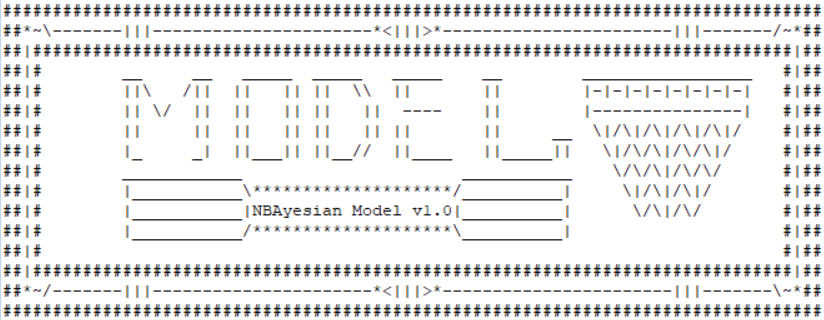


### Exploratory Data Analysis
#### R Libraries
```
library(rjags)
library(coda)
library("corrplot")
# install dplyr for priors
install.packages("dplyr")
library(dplyr)
```
> `rjags`: **R**-based **J**ust **A**nother **G**ibbs **S**ampler - Bayesian Simulation software to help do heavy lifting in calculations
> `coda`: For simulating the JAGS model to find the posterior results of the probabilities of the home team winning the game.
> `corrplot`: Additional Data Visualization support to show correlative relationships
> `dplyr`: Used to help analyze the priors
    - According to my research the library it is a data manipulation tool similar to pandas

#### * `head` and `str` of the Data
```
> head(nba5min)
        Date HomeTeam AwayTeam HomeGameScore AwayGameScore
1 2019-10-22       27       18           103           106
2 2019-10-22       27       18           103           106
3 2019-10-22       27       18           103           106
4 2019-10-22       27       18           103           106
5 2019-10-22       27       18           103           106
6 2019-10-22       27       18           103           106
  HomePointsScoredLast300Seconds AwayPointsScoredLast300Seconds
1                             12                             13
2                             12                             13
3                             12                             13
4                             12                             13
5                             12                             13
6                             12                             13
  HomePointsScoredLast120Seconds AwayPointsScoredLast120Seconds
1                              3                              7
2                              3                              7
3                              3                              7
4                              3                              7
5                              3                              7
6                              3                              7
  HomePointDifferential HomeFGDifferential HomeDRebDifferential
1                    -3        -0.03756684                    0
2                    -3        -0.03756684                    0
3                    -3        -0.04203570                    0
4                    -3        -0.04203570                    0
5                    -3        -0.04203570                    0
6                    -3        -0.04203570                    0
  HomeORebDifferential Home3FGDifferential HomeBlocksDifferential
1                    0         -0.07759374                     -6
2                    1         -0.07759374                     -6
3                    1         -0.07759374                     -6
4                    2         -0.07759374                     -6
5                    2         -0.07759374                     -6
6                    2         -0.07759374                     -6
  HomeStealsDifferential HomeAssistsDifferential
1                      2                      -9
2                      2                      -9
3                      2                      -9
4                      2                      -9
5                      2                      -9
6                      2                      -9
  HomeReboundsDifferential HomeFreeThrowDifferential
1                        0                         9
2                        1                         9
3                        1                         9
4                        2                         9
5                        2                         9
6                        2                         9
  HomeTurnoversDifferential HomeFoulsDifferential SecLeft
1                        -3                    -5     299
2                        -3                    -5     298
3                        -3                    -5     298
4                        -3                    -5     298
5                        -3                    -6     298
6                        -2                    -6     290
  LambdaWID PointsScoredRemaining_Home PointsScoredRemaining_Away
1        14                         14                         11
2        14                         14                         11
3        14                         14                         11
4        14                         14                         11
5        14                         14                         11
6        14                         14                         11
> str(nba5min)
'data.frame':   63945 obs. of  25 variables:
 $ Date                          : chr  "2019-10-22" "2019-10-22" "2019-10-22" "2019-10-22" ...
 $ HomeTeam                      : int  27 27 27 27 27 27 27 27 27 27 ...
 $ AwayTeam                      : int  18 18 18 18 18 18 18 18 18 18 ...
 $ HomeGameScore                 : int  103 103 103 103 103 103 103 103 103 103 ...
 $ AwayGameScore                 : int  106 106 106 106 106 106 109 109 109 109 ...
 $ HomePointsScoredLast300Seconds: int  12 12 12 12 12 12 12 9 9 9 ...
 $ AwayPointsScoredLast300Seconds: int  13 13 13 13 13 13 13 13 13 13 ...
 $ HomePointsScoredLast120Seconds: int  3 3 3 3 3 3 0 0 0 0 ...
 $ AwayPointsScoredLast120Seconds: int  7 7 7 7 7 7 10 8 8 8 ...
 $ HomePointDifferential         : int  -3 -3 -3 -3 -3 -3 -6 -6 -6 -6 ...
 $ HomeFGDifferential            : num  -0.0376 -0.0376 -0.042 -0.042 -0.042 ...
 $ HomeDRebDifferential          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ HomeORebDifferential          : int  0 1 1 2 2 2 2 2 2 2 ...
 $ Home3FGDifferential           : num  -0.0776 -0.0776 -0.0776 -0.0776 -0.0776 ...
 $ HomeBlocksDifferential        : int  -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 ...
 $ HomeStealsDifferential        : int  2 2 2 2 2 2 2 2 2 2 ...
 $ HomeAssistsDifferential       : int  -9 -9 -9 -9 -9 -9 -10 -10 -10 -10 ...
 $ HomeReboundsDifferential      : int  0 1 1 2 2 2 2 2 2 2 ...
 $ HomeFreeThrowDifferential     : int  9 9 9 9 9 9 9 9 9 9 ...
 $ HomeTurnoversDifferential     : int  -3 -3 -3 -3 -3 -2 -2 -2 -2 -1 ...
 $ HomeFoulsDifferential         : int  -5 -5 -5 -5 -6 -6 -6 -6 -6 -6 ...
 $ SecLeft                       : int  299 298 298 298 298 290 269 255 254 249 ...
 $ LambdaWID                     : int  14 14 14 14 14 14 13 13 13 13 ...
 $ PointsScoredRemaining_Home    : int  14 14 14 14 14 14 14 14 14 14 ...
 $ PointsScoredRemaining_Away    : int  11 11 11 11 11 11 8 8 8 8 .
```
#### * Scatterplots
Let's get an initial feel for our potential features and our targets. These did not have a ton of visual cues, but I did notice two nuggets:
1. Higher amount of points scored, the less points remaining to be scored
    - This is a bit of indirect causation, as it is really more reflective of the time left than the points scored
    - We can use time windows to help reflect this
2. In many of the differential stats we will notice the amount of points to be scored actually typically decreases as the differentials grow
    - This might be the data's reflection of teams in blowouts typically take their foot of the gas and might not try to score more & more
    - This might be an interesting non-linear relationship to explore

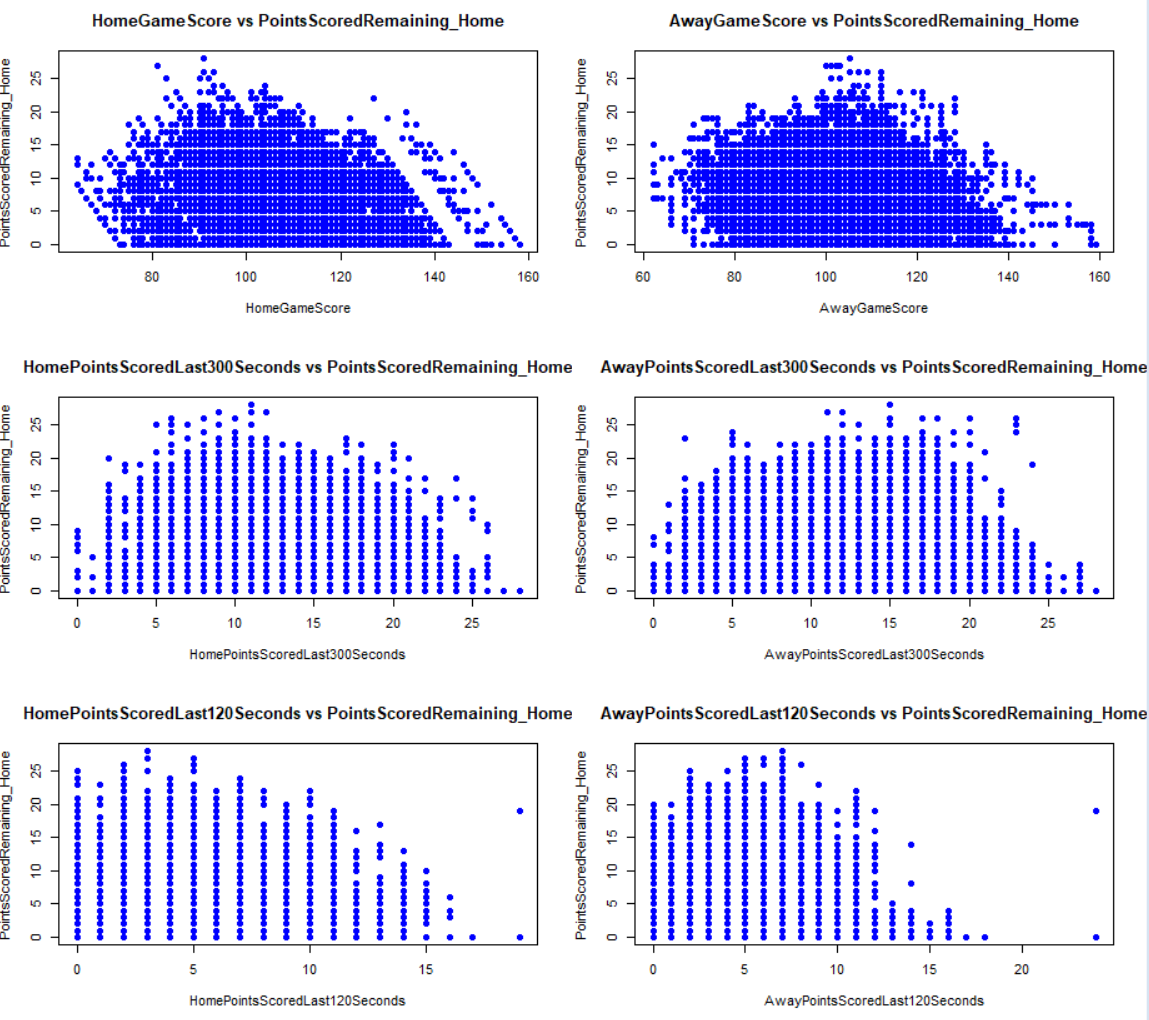

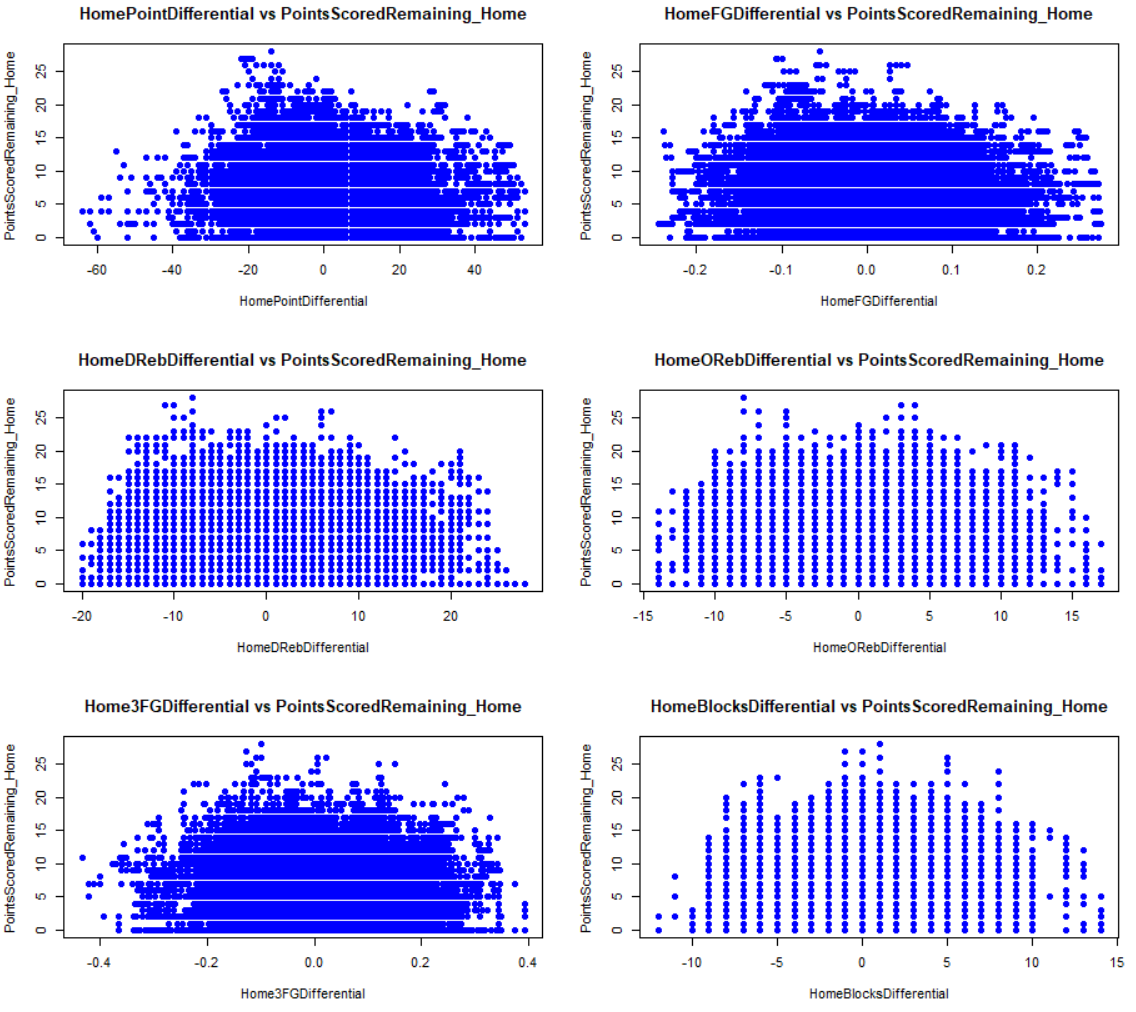

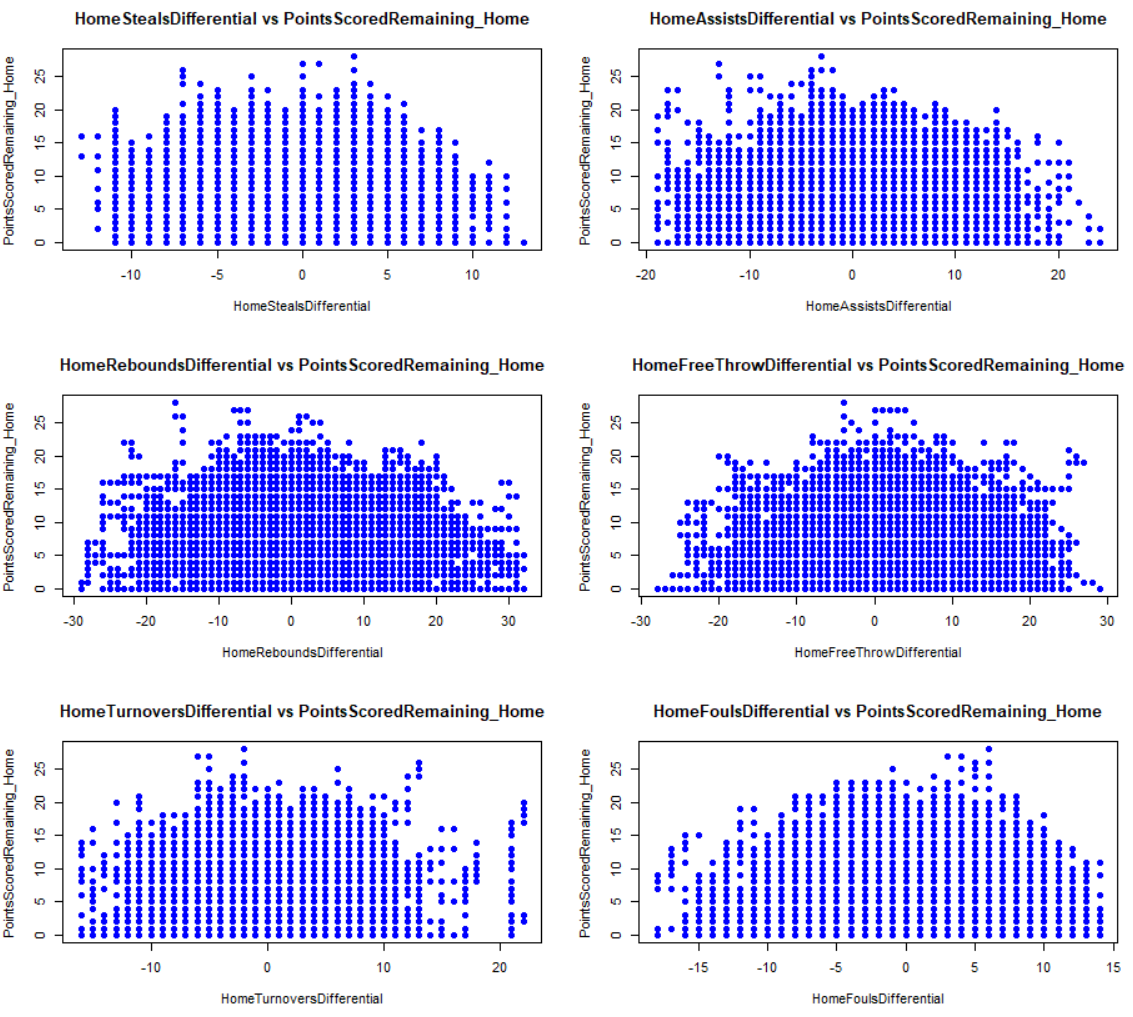

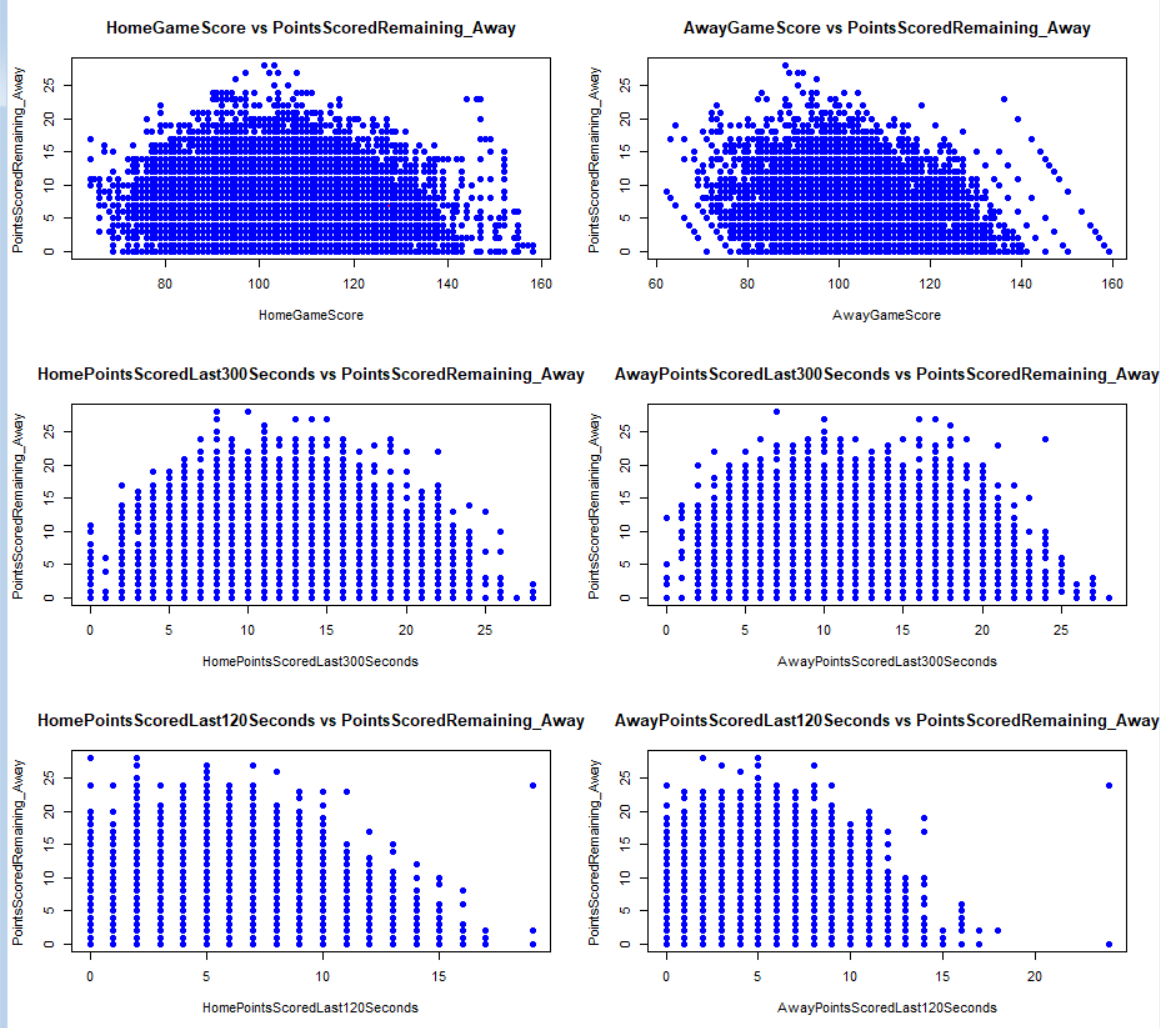

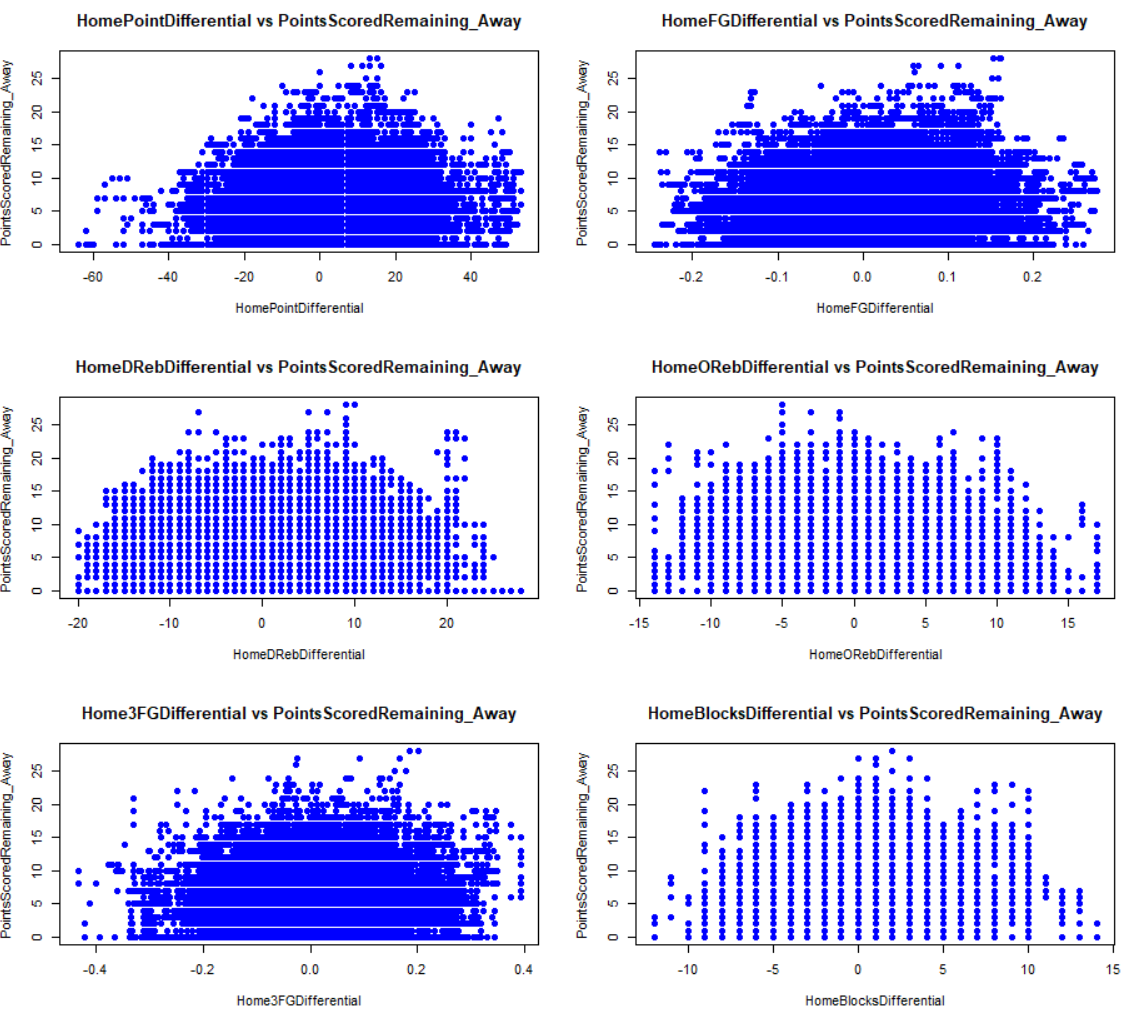

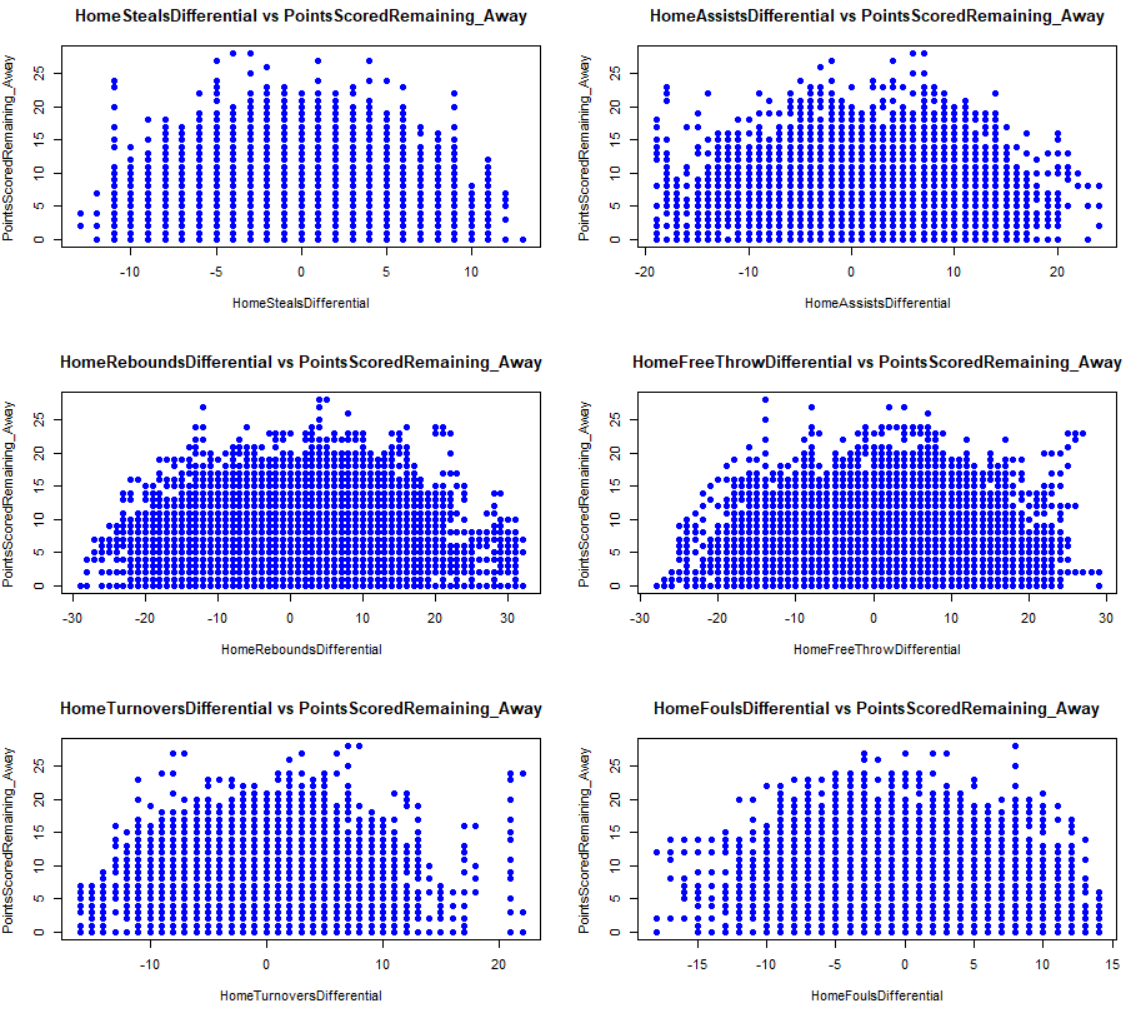

##### Takeaway
The target variables do not seem to have a strong correlational relationship with the features.

#### * Correlation Heatmap
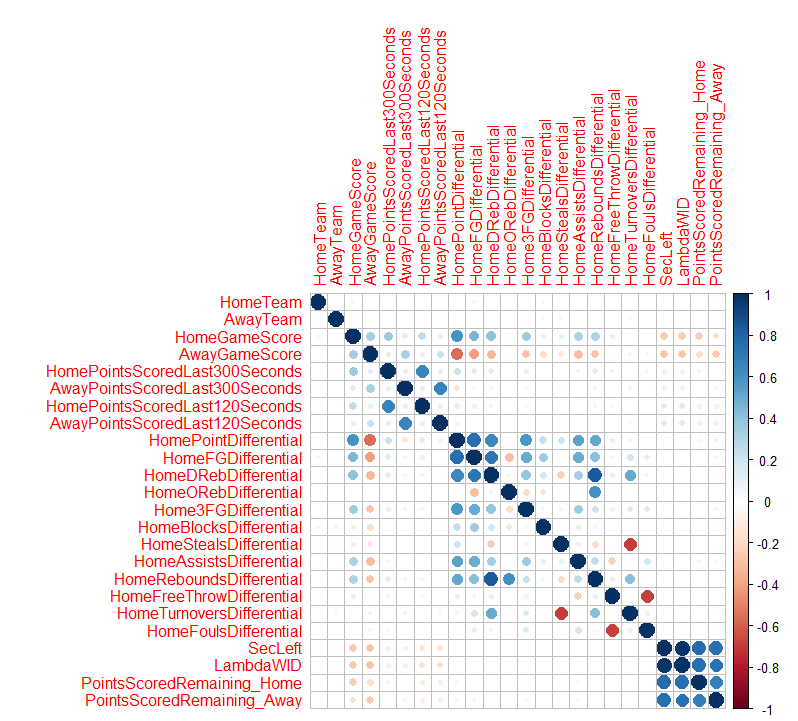

It seems there is not a strong correlation between any of the differential statistics and the points remaining statistics.

##### Collinearity Observed
We can see some strong multi-collinearity, which is to be expected. Some of these statistics have direct causational affects, such as an assist cannot occur without points scored and the field goal increasing. This makes me believe a Laplace prior on the beta coefficients will be appropriate to help further improve feature selection. 

With no strong correlations present in the differential statistics we will introduce some feature engineering to expand our view of the data and hopefully observe some strong relationships to the outcomes.

#### * Feature Engineering
Our feature engineering will mainly just try to give a more robust view of the data. We will apply a variety of transformations and interaction terms to help explore good predictors of the game. These relationships are being explored programmatically with the following functions, so it is good to keep this grain of salt when interpretting their raw values! This is also a pretty robust look at the data, so we will need to group these into batches to analyze their correlational strength with the target varibles.

* Functions for linear transformations, interaction terms, and comparing the values to their lambda window medians
```
# create the interaction terms and transform the variables
transformations <- function(data) {
  # Loop through selected columns
  for (col1 in colnames(data)[4:21]) {
    for (col2 in colnames(data)[4:21]) {
      # Skip when the columns are the same
      if (col1 == col2) {
        next
      }
      
      ## Transformations for col1
      data[[paste0(col1, "^2")]] = data[[col1]]^2
      data[[paste0("LogOf", col1)]] = log(abs(data[[col1]]) + 1e-8)
      data[[paste0("Inverse", col1)]] = 1 / (data[[col1]] + 1e-8)
      data[[paste0("SQRT(", col1, ")")]] = sqrt(abs(data[[col1]]) + 1e-8)

      ## Interaction terms
      # 2nd-degree polynomial
      data[[paste0(col1, "^2*", col2, "^2")]] = (data[[col1]]^2) * (data[[col2]]^2)
      # Powers
      data[[paste0(col1, "^2/", col2)]] = (data[[col1]]^2) / (data[[col2]] + 1e-8)
      data[[paste0(col1, "^2*", col2)]] = (data[[col1]]^2) * data[[col2]]
      data[[paste0(col1, "^", col2)]] = data[[col1]]^(data[[col2]] + 1e-8)
      # Log
      data[[paste0("LogOf", col1, "/", col2)]] = log(abs(data[[col1]]) + 1e-8) / (data[[col2]] + 1e-8)
      data[[paste0("LogOf", col1, "/", col2, "^2")]] = log(abs(data[[col1]]) + 1e-8) / ((data[[col2]]^2) + 1e-8)
      data[[paste0(col1, "/LogOf", col2)]] = data[[col1]] / (log(abs(data[[col2]]) + 1e-8))
      data[[paste0(col1, "^2/LogOf", col2)]] = (data[[col1]]^2) / (log(abs(data[[col2]]) + 1e-8))
      data[[paste0("LogOf", col1, "*", col2)]] = log(abs(data[[col1]]) + 1e-8) * data[[col2]]
      data[[paste0("LogOf", col1, "*", col2, "^2")]] = log(abs(data[[col1]]) + 1e-8) * (data[[col2]]^2)
      data[[paste0(col1, "*LogOf", col2)]] = data[[col1]] * log(abs(data[[col2]]) + 1e-8)
      data[[paste0(col1, "^2*LogOf", col2)]] = (data[[col1]]^2) * log(abs(data[[col2]]) + 1e-8)
      # Inverse
      data[[paste0("Inverse", col1, "/LogOf", col2)]] = (1 / (data[[col1]] + 1e-8)) / log(abs(data[[col2]]) + 1e-8)
      data[[paste0("Inverse", col1, "*LogOf", col2)]] = (1 / (data[[col1]] + 1e-8)) * log(abs(data[[col2]]) + 1e-8)
      data[[paste0("Inverse", col1, "*", col2, "^2")]] = (1 / (data[[col1]] + 1e-8)) * (data[[col2]]^2)
      data[[paste0("Inverse", col1, "*", col2)]] = (1 / (data[[col1]] + 1e-8)) * data[[col2]]
      # Sqrt
      data[[paste0("SQRT", col1, "/", col2, "^2")]] = sqrt(abs(data[[col1]]) + 1e-8) / ((data[[col2]]^2) + 1e-8)
      data[[paste0("SQRT", col1, "/", col2)]] = sqrt(abs(data[[col1]]) + 1e-8) / (data[[col2]] + 1e-8)
      data[[paste0(col1, "^2/SQRT", col2)]] = (data[[col1]]^2) / sqrt(abs(data[[col2]]) + 1e-8)
      data[[paste0(col1, "/SQRT", col2)]] = data[[col1]] / sqrt(abs(data[[col2]]) + 1e-8)
      data[[paste0("SQRT", col1, "*LogOf", col2)]] = sqrt(abs(data[[col1]]) + 1e-8) * log(abs(data[[col2]]) + 1e-8)
      data[[paste0("SQRT", col1, "*", col2, "^2")]] = sqrt(abs(data[[col1]]) + 1e-8) * (data[[col2]]^2)
      data[[paste0("SQRT", col1, "*", col2)]] = sqrt(abs(data[[col1]]) + 1e-8) * data[[col2]]
      data[[paste0("LogOf", col1, "*SQRT", col2)]] = log(abs(data[[col1]]) + 1e-8) * sqrt(abs(data[[col2]]) + 1e-8)
      data[[paste0(col1, "^2*SQRT", col2)]] = (data[[col1]]^2) * sqrt(abs(data[[col2]]) + 1e-8)
    }
  }
  return(data)
}

## median thresholds and differences based on lambda windows # ChatGPT come up with the design here
lambdaWindowMedianData = function(data) {
  for (col in colnames(data)[4:21]) {
    # Binary column for whether value is above/below lambda window median
    data[[paste0("LamWin_MedianThreshold_", col)]] = with(data,
      ifelse(
        data[[col]] > ave(data[[col]], data[["LambdaWID"]], FUN = function(x) median(x, na.rm = TRUE)),
        1,
        0
      )
    )
    
    # Difference from median column
    data[[paste0("LamWin_DifferenceFromMedian_", col)]] = with(data,
      data[[col]] - ave(data[[col]], data[["LambdaWID"]], FUN = function(x) median(x, na.rm = TRUE))
    )
  }
  return(data)  # Return the modified dataset
}

robustNBA = transformations(nba5min)
robustNBA = lambdaWindowMedianData(robustNBA)
```

Let's see how many columns this is:
```
> ncol(robustNBA)
[1] 7783
```
Let's see how many of these have at least some correlational strength to our targets

* Breakdown in batches to avoid overwhelming CPU
```
cor_col = character(0)
bgn_idx = 2
step_size = 20
total_cols = ncol(robustNBA)
key_columns = c("PointsScoredRemaining_Home", "PointsScoredRemaining_Away")
key_indices = match(key_columns, colnames(robustNBA))

while (bgn_idx <= total_cols) {
  end_idx = min(bgn_idx + step_size - 1, total_cols)
  Cor = cor(robustNBA[, c(bgn_idx:end_idx, key_indices)], use = "complete.obs")
  threshold = 0.1
  columns = colnames(robustNBA[, bgn_idx:end_idx])[apply(
    abs(Cor[, (ncol(Cor) - length(key_columns) + 1):ncol(Cor)]) > threshold, 1, any
  )]
  cor_col = unique(c(cor_col, columns))
  bgn_idx = bgn_idx + step_size
}

cor_col = unique(na.omit(c(cor_col, key_columns)))
cor_col
filtered_data = robustNBA[, cor_col]
```
Looking at our strongest correlating values, we see a lot of values concerning the home and away game score, as is to be expected. Due to the complicated, random outcomes of basketball, we also noticed none of these have particularly strong correlational strengths. We will need to perform further discernment to help perform feature selection. We will introduce LASSO regularization to help in the algorithm. While it would be ideal to have strong correlations, narrowing down the values from the original ~8000 will be very helpful to not overwhelm JAGS.

##### Collinearity Still Observed

#### * Exploring Over Dispersion with Boxplots
Let's see if overdispersion is affecting our data:

```
# Away:
# A tibble: 15 × 3
   LambdaWID mean_away var_away
       <int>     <dbl>    <dbl>
 1         1     0.169    0.423
 2         2     0.860    1.42 
 3         3     1.32     2.34 
 4         4     1.71     3.80 
 5         5     2.21     5.06 
 6         6     2.69     5.81 
 7         7     3.52     6.72 
 8         8     4.60     8.43 
 9         9     5.74     9.60 
10        10     6.87    10.9  
11        11     7.94    12.8  
12        12     9.07    14.9  
13        13    10.1     16.0  
14        14    11.2     16.9  
15        15    11.5     16.8

# Home:
# A tibble: 15 × 3
   LambdaWID mean_home var_home
       <int>     <dbl>    <dbl>
 1         1     0.211    0.479
 2         2     0.959    1.53 
 3         3     1.12     1.85 
 4         4     1.63     3.39 
 5         5     2.22     4.87 
 6         6     2.71     5.40 
 7         7     3.51     6.76 
 8         8     4.75     8.33 
 9         9     5.93    10.0  
10        10     6.92    11.3  
11        11     8.17    12.9  
12        12     9.36    14.3  
13        13    10.5     16.3  
14        14    11.6     17.3  
15        15    11.8     16.1
```

This unfortunately is being affected. We can also see this visually with the box plots. You will also notice two anomolous visuals here as well:
- `LambdaWID` group `1` has a massive outlier in both. Upon inspecting this in Excel, there does not seem to be much explanation and since this is not a time series model, it should not be of signficant consequence to remove these.
    
- We also will notice that `LambdaWID` 15 seems to not match the behavior/structure of the other box and whiskers. This is easily explainable, as it stems on from the function used to create the Lambda windows. The window range for `LambdaWID` 15 is 300:360, which means the points plotted here are the values which were observed *exactly* at 300 seconds. We will remove these as well.  

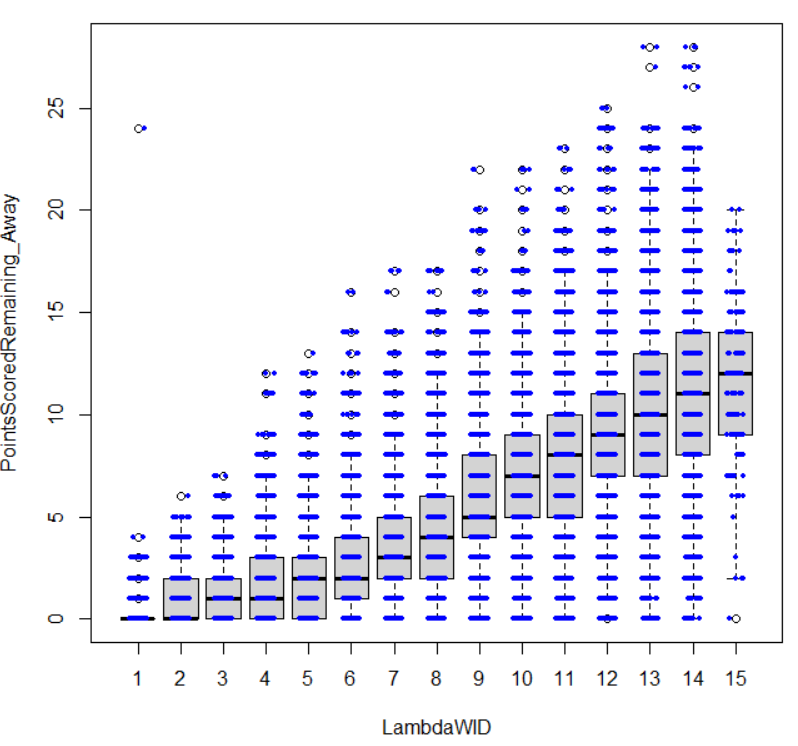

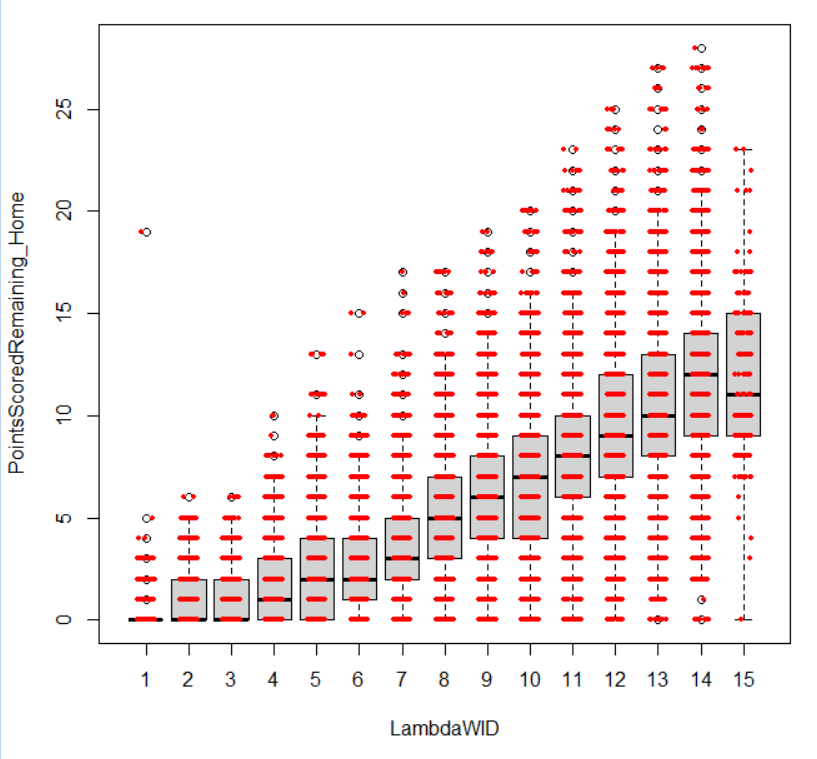

We will remove these and rerun the analyses:

```
# away
# A tibble: 14 × 3
   LambdaWID mean_away var_away
       <int>     <dbl>    <dbl>
 1         1     0.164    0.298
 2         2     0.860    1.42 
 3         3     1.32     2.34 
 4         4     1.71     3.80 
 5         5     2.21     5.06 
 6         6     2.69     5.81 
 7         7     3.52     6.72 
 8         8     4.60     8.43 
 9         9     5.74     9.60 
10        10     6.87    10.9  
11        11     7.94    12.8  
12        12     9.07    14.9  
13        13    10.1     16.0  
14        14    11.2     16.9

# home
# A tibble: 14 × 3
   LambdaWID mean_home var_home
       <int>     <dbl>    <dbl>
 1         1     0.207    0.401
 2         2     0.959    1.53 
 3         3     1.12     1.85 
 4         4     1.63     3.39 
 5         5     2.22     4.87 
 6         6     2.71     5.40 
 7         7     3.51     6.76 
 8         8     4.75     8.33 
 9         9     5.93    10.0  
10        10     6.92    11.3  
11        11     8.17    12.9  
12        12     9.36    14.3  
13        13    10.5     16.3  
14        14    11.6     17.3 
```

These do not do anything to fix the overdispersion prevelant in so much of the data. Let's perform some transformations to attempt to resolve the overdispersion for a poisson distribution.

##### Transforming the Target to deal with this
- Log: No resolvement
    - Negatives are caused my infintismally small values added for zeroes
    - We see this shifts from overdispersion to underdispersion, *quickly*
```
log_grouped_stats = nba5min %>%
  group_by(LambdaWID) %>%
  summarize(
    mean_away = mean(log(abs(PointsScoredRemaining_Away+1e-8)), na.rm = TRUE),
    var_away = var(log(abs(PointsScoredRemaining_Away+1e-8)), na.rm = TRUE)
  )
log_grouped_stats

# A tibble: 14 × 3
   LambdaWID mean_away var_away
       <int>     <dbl>    <dbl>
 1         1  -16.6       31.0 
 2         2  -10.5       88.2 
 3         3   -8.34      92.4 
 4         4   -7.18      91.3 
 5         5   -5.58      85.4 
 6         6   -3.75      71.7 
 7         7   -1.59      48.3 
 8         8   -0.0342    27.6 
 9         9    0.930     14.3 
10        10    1.37       9.55
11        11    1.75       4.84
12        12    1.96       3.29
13        13    2.14       2.08
14        14    2.29       1.26
```

- Square Root: This actually shifted the results to *under*dispersion! This makes sense due to how we use absolute values which shorten the interpretable range for the variance and create a smaller than actual variance.
```
sqrt_grouped_stats = nba5min %>%
  group_by(LambdaWID) %>%
  summarize(
    mean_away = mean(sqrt(abs(PointsScoredRemaining_Away+1e-8)), na.rm = TRUE),
    var_away = var(sqrt(abs(PointsScoredRemaining_Away+1e-8)), na.rm = TRUE)
  )
sqrt_grouped_stats

# A tibble: 14 × 3
   LambdaWID mean_home var_home
       <int>     <dbl>    <dbl>
 1         1     0.150    0.184
 2         2     0.642    0.548
 3         3     0.726    0.596
 4         4     0.925    0.777
 5         5     1.17     0.859
 6         6     1.38     0.817
 7         7     1.65     0.773
 8         8     2.02     0.660
 9         9     2.32     0.570
10        10     2.53     0.512
11        11     2.77     0.468
12        12     2.99     0.431
13        13     3.17     0.434
14        14     3.34     0.413
```

##### Takeaways
Our target data is showing clear signs of overdispersion. While the goal was to use a poisson approach to model the points remaining, our assumption of equal variance and mean is violated within this data even after performing transformations on the target.

A good option is the negative binomial distribution, an extension of Poisson regression that accounts for variance exceeding the mean by introducing a dispersion parameter, commonly referred to as $\phi$ or $\theta$ depending on the context. In count data models, $\phi$ is often used to represent this parameter. This regularization parameter makes the negative binomial distribution a better choice for handling the overdispersion observed in our dataset.


#### * Performing Feature Selection
##### Narrowing down the features further
If we inspect the `filtered_data` object, we will notice a majority of the values we see are related to either `HomeGameScore` or `AwayGameScore`. We currently have 349 features included in this object.

```
[332] "SQRTHomeFreeThrowDifferential*HomeGameScore^2"                         
[333] "SQRTHomeFreeThrowDifferential/AwayGameScore^2"                         
[334] "SQRTHomeFreeThrowDifferential*AwayGameScore^2"                         
[335] "SQRTHomeFreeThrowDifferential*HomePointsScoredLast120Seconds^2"        
[336] "SQRTHomeFreeThrowDifferential*HomePointsScoredLast120Seconds"          
[337] "SQRTHomeTurnoversDifferential/HomeGameScore^2"                         
[338] "SQRTHomeTurnoversDifferential*HomeGameScore^2"                         
[339] "SQRTHomeTurnoversDifferential*HomeFGDifferential"                      
[340] "HomeFoulsDifferential^2*HomeGameScore^2"                               
[341] "SQRTHomeFoulsDifferential*HomeGameScore^2"                             
[342] "SQRTHomeFoulsDifferential*HomeGameScore"                               
[343] "HomeFoulsDifferential^2*AwayGameScore^2"                               
[344] "SQRTHomeFoulsDifferential*AwayGameScore^2"                             
[345] "SQRTHomeFoulsDifferential*AwayGameScore"                               
[346] "SQRTHomeFoulsDifferential*HomePointsScoredLast120Seconds^2"            
[347] "SQRTHomeFoulsDifferential*HomePointsScoredLast120Seconds"              
[348] "SQRTHomeFoulsDifferential*AwayPointsScoredLast120Seconds^2"            
[349] "SQRTHomeFoulsDifferential*AwayPointsScoredLast120Seconds"               
```

These obviously have collinearity amongest each other. 349 columns is also a high amount of dimensionality. We can reduce these dimensions by eliminating all columns which include `GameScore` in their column name if they are not within the 3 strongest correlative features to our target variables. We will want to keep the `HomeGameScore` and `AwayGameScore` variables as well whether or not they are the strongest correlative features for interpretability. To ensure this is not a repeated value, we will use `unique()`. Since we are using two target variables, we will also use the stronger of the two correlations between the targets.

```
gamescore_cols = grep("GameScore", colnames(filtered_data), value = TRUE)
non_gamescore_cols = setdiff(colnames(filtered_data), gamescore_cols)
Cor = cor(filtered_data[, c(gamescore_cols, "PointsScoredRemaining_Home", "PointsScoredRemaining_Away")], use = "complete.obs")
cor_with_target = apply(abs(Cor[gamescore_cols, c("PointsScoredRemaining_Home", "PointsScoredRemaining_Away")]), 1, max)
top_3_gamescore_features = names(sort(cor_with_target, decreasing = TRUE))[1:3]
retained_columns = unique(c("HomeGameScore","AwayGameScore",non_gamescore_cols, top_3_gamescore_features))
filtered_data = filtered_data[, retained_columns]
```

Once again if inspect this `retained_columns` output, we will notice another highly repetitive feature type `'PointsScoredLast\\d{3,}Seconds'`. We should perform a similar operation here. Interestingly, only `HomePointsScoredLast120Seconds` made a strong enough correlation to appear, so we will only include this of the other similar base features.

```
  [1] "HomePointsScoredLast120Seconds" # only one of the 'PointsScoredLast\\d{3,}Seconds' variations which appeared above 0.1 corr strength           
  [2] "SecLeft" 
  [3] "LambdaWID"
```

Performing the filtering:

```
points_scored_cols = grep("PointsScoredLast\\d{3,}Seconds", colnames(filtered_data), value = TRUE)
non_points_scored_cols = setdiff(colnames(filtered_data), points_scored_cols)
Cor = cor(filtered_data[, c(points_scored_cols, "PointsScoredRemaining_Home", "PointsScoredRemaining_Away")], use = "complete.obs")
cor_with_target = apply(abs(Cor[points_scored_cols, c("PointsScoredRemaining_Home", "PointsScoredRemaining_Away")]), 1, max)
top_3_points_scored_features = names(sort(cor_with_target, decreasing = TRUE))[1:3]
retained_columns = unique(c("HomePointsScoredLast120Seconds",non_points_scored_cols, top_3_points_scored_features))
filtered_data = filtered_data[, retained_columns]
```

And let's see how many dimensions this:

```
> ncol(filtered_data)
[1] 14
```

This will be a much more reasonable selection list to sort through for our LASSO.
```
> retained_columns
 [1] "HomePointsScoredLast120Seconds"                                        
 [2] "HomeGameScore"                                                         
 [3] "AwayGameScore"                                                         
 [4] "SecLeft"                                                               
 [5] "LambdaWID"                                                             
 [6] "PointsScoredRemaining_Home"                                            
 [7] "PointsScoredRemaining_Away"                                            
 [8] "SQRTHomeTurnoversDifferential*HomeFGDifferential"     # only real ingame play statistic interaction or value                 
 [9] "LogOfHomeGameScore*SQRTAwayGameScore"                               
[10] "SQRTAwayGameScore*LogOfHomeGameScore"                               
[11] "SQRTHomeGameScore*AwayGameScore"                                    
[12] "HomePointsScoredLast120Seconds^2*AwayPointsScoredLast120Seconds"    
[13] "HomePointsScoredLast120Seconds^2*SQRTAwayPointsScoredLast120Seconds"
[14] "SQRTAwayPointsScoredLast120Seconds*HomePointsScoredLast120Seconds^2"
```
##### LASSO
Recall our very robust dataset of interaction terms and transformations for the data. Since most of these have a good amount of multi-collinearity due to their creation, we will want to incorporate a way of performing programmatic feature selection. Using a Laplace prior allows us to do this and is commonly referred to as **LASSO (L1)** regularization. We also will use a relatively mild `r` parameter to account for the mild overdispersion present in the data. Since our model will be utilizing random intercepts based on time windows for Lambda, our LASSO model will look slightly different than a typical baseline model:

```
## LASSO
# laplace distribution for feature selection
ddexp = function(x, mu, tau) {
  0.5*tau*exp(-tau*abs(x-mu)) 
}

lasso_string = " model {
  for (i in 1:N) { 
    home_y[i] ~ dnegbin(home_p[i], r)
    away_y[i] ~ dnegbin(away_p[i], r)
    home_p[i] = r / (r + home_mu[i])
    away_p[i] = r / (r + away_mu[i])
    log(home_mu[i]) = bhome_window[lambdaWindow[i]] + inprod(X[i,], b_h[1:P]) 
    log(away_mu[i]) = baway_window[lambdaWindow[i]] + inprod(X[i,], b_a[1:P])  
  } 

  for (w in 1:max(lambdaWindow)) {
    bhome_window[w] ~ dnorm(0, tau)
    baway_window[w] ~ dnorm(0, tau) 
  }

  for (j in 1:P) {
    b_h[j] ~ ddexp(0.0, 1.0)
    b_a[j] ~ ddexp(0.0, 1.0)
  }

  tau ~ dgamma(1.0, 1.0)
  r ~ dgamma(5.0, 0.1)
}"
```

Readying the data for JAGS:
```
predictors = colnames(filtered_data)[!(colnames(filtered_data) %in% c("PointsScoredRemaining_Home","PointsScoredRemaining_Away", "LambdaWID"))]
data_jags = list(
  X = as.matrix(scale(filtered_data[, predictors])),
  home_y = filtered_data[,"PointsScoredRemaining_Home"],
  away_y = filtered_data[,"PointsScoredRemaining_Away"],
  lambdaWindow = filtered_data$LambdaWID,
  N = max(filtered_data$PointsScoredRemaining_Home),
  P = length(predictors)
)
```

We will track: `params = c("b_a","b_h","r","u","tau_u")`

Running the model:
```
lasso_mod = jags.model(textConnection(lasso_string),data=data_jags,n.chains=3)
update(lasso_mod,1000) # burnin

mod_sim = coda.samples(lasso_mod,variable.names=params,n.iter=5e3)
mod_csim = as.mcmc(do.call(rbind,mod_sim))

```

Return the LASSO values:
```
summary_stats = summary(mod_sim)

#output of the beta coefficients:
Iterations = 11001:111000
Thinning interval = 1 
Number of chains = 2 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                  Mean       SD  Naive SE Time-series SE
b_a[1]       -0.003101 0.015155 3.389e-05      1.863e-04
b_a[2]       -0.756883 0.078465 1.755e-04      7.404e-03
b_a[3]       -1.666982 0.165722 3.706e-04      1.602e-02
b_a[4]        0.536322 0.054335 1.215e-04      2.449e-03
b_a[5]        0.039485 0.009145 2.045e-05      4.461e-05
b_a[6]        1.217053 0.729482 1.631e-03      2.323e-01
b_a[7]       -0.018217 0.716909 1.603e-03      2.278e-01
b_a[8]        0.844451 0.142433 3.185e-04      1.025e-02
b_a[9]        0.067312 0.040994 9.166e-05      7.199e-04
b_a[10]      -0.036013 0.765386 1.711e-03      1.774e-01
b_a[11]       0.029157 0.764061 1.708e-03      1.764e-01
b_h[1]        0.019769 0.015038 3.363e-05      1.888e-04
b_h[2]       -0.595981 0.073810 1.650e-04      6.494e-03
b_h[3]       -1.097043 0.153509 3.433e-04      1.399e-02
b_h[4]        0.556642 0.054322 1.215e-04      2.412e-03
b_h[5]       -0.017629 0.009209 2.059e-05      4.471e-05
b_h[6]        0.275938 0.779174 1.742e-03      1.721e-01
b_h[7]        0.492479 0.790257 1.767e-03      1.790e-01
b_h[8]        0.650722 0.142278 3.181e-04      1.028e-02
b_h[9]        0.094200 0.041384 9.254e-05      7.417e-04
b_h[10]      -0.560741 0.591711 1.323e-03      1.368e-01
b_h[11]       0.502491 0.591420 1.322e-03      1.385e-01
b_window[1]  -0.916207 0.109545 2.450e-04      3.318e-03
b_window[2]   0.592913 0.093253 2.085e-04      3.255e-03
b_window[3]   0.868818 0.086634 1.937e-04      3.138e-03
b_window[4]   1.102762 0.070079 1.567e-04      2.889e-03
b_window[5]   1.261491 0.061448 1.374e-04      2.477e-03
b_window[6]   1.461409 0.054066 1.209e-04      2.056e-03
b_window[7]   1.610188 0.037858 8.465e-05      1.494e-03
b_window[8]   1.743143 0.022828 5.105e-05      6.919e-04
b_window[9]   1.773233 0.015752 3.522e-05      6.421e-05
b_window[10]  1.744980 0.025000 5.590e-05      8.838e-04
b_window[11]  1.733020 0.039484 8.829e-05      1.670e-03
b_window[12]  1.666271 0.055747 1.247e-04      2.412e-03
b_window[13]  1.607977 0.072765 1.627e-04      3.215e-03
b_window[14]  1.523699 0.089951 2.011e-04      4.031e-03
r             9.794316 0.385986 8.631e-04      1.095e-03
tau           0.508549 0.180043 4.026e-04      4.036e-04

```
So we see a couple of the coefficients were fairly close to zero. The coefficients at beta coefficient 1 and 5 are pretty close to zero, representing `HomePointsScoredLast120Seconds` and `SQRTHomeTurnoversDifferential*HomeFGDifferential` and convergence diagnostics indicate these reach convergence. However, if we check the convergence diagnostics for the others, most of the coefficients did not reach covergence. The interaction terms from coefficients 6-11 all did not come close except **9**. Let's look at the diagnostics:

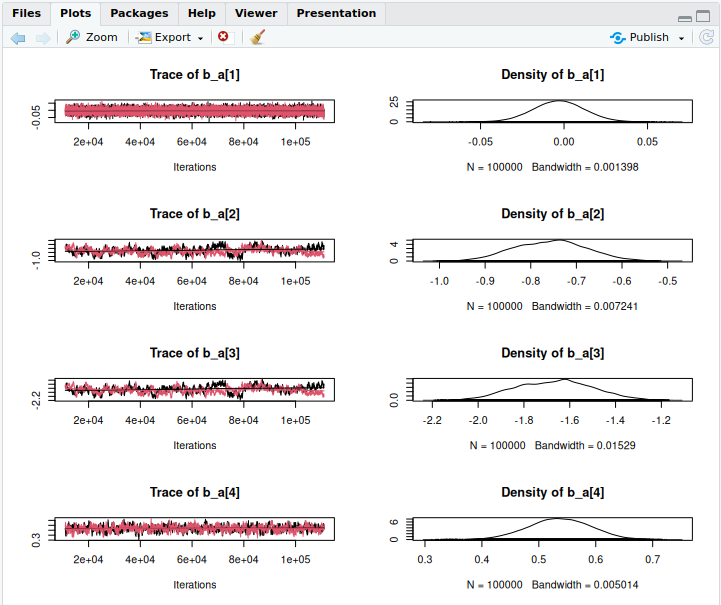

Looking at our traceplots, we can quickly see the lack of convergence. `b_a[1]` appears to converge as stated earlier, but most of the rest of traces indicate similar issue as here.

Next, the Gelman-Rubin indicates to us variability between the chains and indicates convergence if at 1. We can see this is not quite the case for many of the coefficients:

```
> gelman.diag(mod_sim)
Potential scale reduction factors:

             Point est. Upper C.I.
b_a[1]             1.00       1.01
b_a[2]             1.10 *     1.38
b_a[3]             1.12 *     1.42
b_a[4]             1.01       1.03
b_a[5]             1.00       1.00
b_a[6]             2.49 *     7.36
b_a[7]             2.30 *     6.66
b_a[8]             1.00       1.02
b_a[9]             1.00       1.01
b_a[10]            2.12 *     4.71
b_a[11]            2.12 *     4.69
b_h[1]             1.00       1.00
b_h[2]             1.00       1.02
b_h[3]             1.00       1.01
b_h[4]             1.01       1.03
b_h[5]             1.00       1.00
b_h[6]             2.50 *     4.95
b_h[7]             2.45 *     4.91
b_h[8]             1.01       1.02
b_h[9]             1.00       1.00
b_h[10]            1.72 *     3.16
b_h[11]            1.72 *     3.16
b_window[1]        1.00       1.01
b_window[2]        1.00       1.02
b_window[3]        1.00       1.02
b_window[4]        1.01       1.02
b_window[5]        1.01       1.02
b_window[6]        1.00       1.02
b_window[7]        1.01       1.02
b_window[8]        1.00       1.01
b_window[9]        1.00       1.00
b_window[10]       1.00       1.02
b_window[11]       1.01       1.02
b_window[12]       1.01       1.02
b_window[13]       1.01       1.03
b_window[14]       1.01       1.03
r                  1.00       1.00
tau                1.00       1.00

Multivariate psrf

3.5
```
This is showing issues surrounding the interaction terms regarding game score. And we can see with `effectiveSize(mod_sim)` that we are not getting large effective sample sizes on these problem spots:

```
> effectiveSize(mod_sim)
      b_a[1]       b_a[2]       b_a[3]       b_a[4]       b_a[5]       b_a[6] 
  6621.20261    112.81210    107.14663    491.91782  42040.93489     15.96219 
      b_a[7]       b_a[8]       b_a[9]      b_a[10]      b_a[11]       b_h[1] 
    15.76242    194.19219   3240.19333     17.68629     17.92051   6349.44554 
      b_h[2]       b_h[3]       b_h[4]       b_h[5]       b_h[6]       b_h[7] 
   127.02236    118.43527    506.66302  42434.30995     17.03708     19.40570 
      b_h[8]       b_h[9]      b_h[10]      b_h[11]  b_window[1]  b_window[2] 
   191.88613   3115.22093     20.00847     19.31645   1098.46132    822.61900 
 b_window[3]  b_window[4]  b_window[5]  b_window[6]  b_window[7]  b_window[8] 
   765.26656    591.93517    616.27064    693.14472    648.80282   1100.07963 
 b_window[9] b_window[10] b_window[11] b_window[12] b_window[13] b_window[14] 
 60511.48487    799.88567    560.25487    533.80138    511.93847    498.04373
```

So obviously we have not reached convergence. The insights here definitely need to be taken with a large grain of salt considering the overall model really did not come that close to convergence.

Let's see if we can get better results with a Ridge regression to deal with the multicollinearity. We will also add more iterations to the burnin.

##### Ridge
Ridge is another regularization method which penalizes coefficients with collinearity and keeping them small in magnitude, but typically **not zero**. This is will be useful to further reduce our features as we have multiple terms derived from the each other or common variables. Just like before, we will incorporate the random intercept model to help better reflect how the final model will be structured. We will again use a relatively small prior for our `r` value to reflect the mild overdispersion observed in the data. 

```
ridge_string = "
model {
  for (i in 1:N) {
    home_y[i] ~ dnegbin(home_p[i], r)
    away_y[i] ~ dnegbin(away_p[i], r)
    home_p[i] = r / (r + home_mu[i])
    away_p[i] = r / (r + away_mu[i])
    log(home_mu[i]) = b_window[meanWindow[i]] + inprod(X[i,], b_h[1:P])
    log(away_mu[i]) = b_window[meanWindow[i]] + inprod(X[i,], b_a[1:P])
  }

  for (w in 1:max(meanWindow)) {
    b_window[w] ~ dnorm(0,tau_w)
  }

  for (j in 1:P) {
    b_h[j] ~ dnorm(0.0, tau_b)
    b_a[j] ~ dnorm(0.0, tau_b)
  }

  tau_w ~ dgamma(1.0,1.0)
  tau_b = 1 / sigma_b^2
  sigma_b ~ dunif(0, 10)

  r ~ dgamma(5.0, 0.1)
}
"

predictors = colnames(subset)[!(colnames(subset) %in% c("PointsScoredRemaining_Home","PointsScoredRemaining_Away", "LambdaWID"))]
data_jags = list(
  X = as.matrix(scale(subset[, predictors])),
  home_y = subset[,"PointsScoredRemaining_Home"],
  away_y = subset[,"PointsScoredRemaining_Away"],
  meanWindow = subset$LambdaWID,
  N = length(subset$PointsScoredRemaining_Home),
  P = length(predictors)
)

params = c("b_h","b_a","b_window")

ridge_mod = jags.model(textConnection(ridge_string),data=data_jags,n.chains=3)
update(ridge_mod,5e4) # give this some good burnin

mod_sim = coda.samples(ridge_mod,variable.names=params,n.iter=1e5)
mod_csim = as.mcmc(do.call(rbind,mod_sim))

summary_stats = summary(mod_sim)
summary_stats
```

Now let's look at the beta coefficient values:
```
Iterations = 51001:151000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                  Mean       SD  Naive SE Time-series SE
b_a[1]       -0.002728 0.015185 2.772e-05      1.562e-04
b_a[2]       -0.687238 0.078889 1.440e-04      6.220e-03
b_a[3]       -1.519774 0.166657 3.043e-04      1.347e-02
b_a[4]        0.537429 0.056649 1.034e-04      2.153e-03
b_a[5]        0.039356 0.009111 1.663e-05      3.605e-05
b_a[6]        0.451152 0.425906 7.776e-04      5.915e-02
b_a[7]        0.654130 0.422330 7.711e-04      6.017e-02
b_a[8]        0.753831 0.138363 2.526e-04      7.903e-03
b_a[9]        0.071055 0.041043 7.493e-05      5.953e-04
b_a[10]       0.045702 0.533017 9.732e-04      7.388e-02
b_a[11]      -0.056232 0.534036 9.750e-04      7.485e-02
b_h[1]        0.020245 0.015171 2.770e-05      1.562e-04
b_h[2]       -0.565696 0.081687 1.491e-04      6.719e-03
b_h[3]       -1.033368 0.170192 3.107e-04      1.432e-02
b_h[4]        0.557845 0.056669 1.035e-04      2.147e-03
b_h[5]       -0.017893 0.009191 1.678e-05      3.671e-05
b_h[6]        0.455182 0.477810 8.724e-04      8.988e-02
b_h[7]        0.267172 0.481282 8.787e-04      9.054e-02
b_h[8]        0.617020 0.142747 2.606e-04      8.555e-03
b_h[9]        0.096554 0.041622 7.599e-05      6.049e-04
b_h[10]       0.007387 0.489696 8.941e-04      8.311e-02
b_h[11]      -0.068173 0.490240 8.951e-04      8.370e-02
b_window[1]  -0.914530 0.112032 2.045e-04      2.864e-03
b_window[2]   0.595849 0.095740 1.748e-04      2.753e-03
b_window[3]   0.871375 0.089214 1.629e-04      2.709e-03
b_window[4]   1.105166 0.072523 1.324e-04      2.497e-03
b_window[5]   1.263450 0.063498 1.159e-04      2.136e-03
b_window[6]   1.462755 0.055834 1.019e-04      1.798e-03
b_window[7]   1.611397 0.039067 7.133e-05      1.306e-03
b_window[8]   1.743234 0.023375 4.268e-05      5.978e-04
b_window[9]   1.773047 0.015738 2.873e-05      5.287e-05
b_window[10]  1.744017 0.025663 4.685e-05      7.334e-04
b_window[11]  1.732097 0.040906 7.468e-05      1.429e-03
b_window[12]  1.665590 0.058074 1.060e-04      2.137e-03
b_window[13]  1.606482 0.075823 1.384e-04      2.840e-03
b_window[14]  1.521459 0.093816 1.713e-04      3.563e-03

2. Quantiles for each variable:

                  2.5%      25%       50%      75%      97.5%
b_a[1]       -0.032487 -0.01295 -0.002736  0.00751  0.0270901
b_a[2]       -0.840212 -0.74145 -0.687152 -0.63289 -0.5294832
b_a[3]       -1.841511 -1.63422 -1.519931 -1.40499 -1.1832873
b_a[4]        0.426303  0.49957  0.537370  0.57578  0.6483039
b_a[5]        0.021486  0.03320  0.039354  0.04551  0.0571859
b_a[6]       -0.556087  0.19406  0.474112  0.72238  1.2451555
b_a[7]       -0.081882  0.37472  0.623785  0.88709  1.6854775
b_a[8]        0.492323  0.65916  0.753374  0.84699  1.0249180
b_a[9]       -0.009935  0.04348  0.071126  0.09876  0.1508924
b_a[10]      -1.017455 -0.31245  0.059447  0.41396  1.0355842
b_a[11]      -1.040226 -0.42460 -0.067561  0.30010  1.0007700
b_h[1]       -0.009664  0.01002  0.020277  0.03050  0.0498985
b_h[2]       -0.723950 -0.62028 -0.566947 -0.51321 -0.3988149
b_h[3]       -1.364694 -1.14722 -1.035900 -0.92346 -0.6876217
b_h[4]        0.446650  0.51995  0.557884  0.59620  0.6691060
b_h[5]       -0.035869 -0.02411 -0.017853 -0.01168  0.0001044
b_h[6]       -0.490129  0.10673  0.524208  0.82371  1.2245284
b_h[7]       -0.541321 -0.10113  0.197838  0.61485  1.2220501
b_h[8]        0.327928  0.52224  0.617934  0.71632  0.8866102
b_h[9]        0.013710  0.06877  0.096906  0.12466  0.1778552
b_h[10]      -1.100042 -0.27277  0.026786  0.31999  0.9342202
b_h[11]      -0.989340 -0.38276 -0.087380  0.21496  1.0397648
b_window[1]  -1.136212 -0.98991 -0.914083 -0.83864 -0.6974883
b_window[2]   0.407514  0.53159  0.596334  0.66035  0.7832801
b_window[3]   0.696249  0.81132  0.871294  0.93169  1.0462757
b_window[4]   0.962337  1.05638  1.105378  1.15424  1.2463658
b_window[5]   1.138591  1.22083  1.263446  1.30631  1.3878188
b_window[6]   1.353073  1.42535  1.462726  1.50037  1.5718926
b_window[7]   1.534551  1.58518  1.611354  1.63775  1.6875411
b_window[8]   1.697317  1.72746  1.743308  1.75901  1.7888823
b_window[9]   1.742122  1.76245  1.773086  1.78370  1.8038518
b_window[10]  1.693598  1.72672  1.744052  1.76120  1.7943612
b_window[11]  1.651961  1.70453  1.732024  1.75954  1.8126516
b_window[12]  1.551864  1.62630  1.665552  1.70455  1.7796456
b_window[13]  1.458184  1.55513  1.606479  1.65713  1.7552367
b_window[14]  1.337688  1.45789  1.521491  1.58406  1.7058589
```
Unfortunately, this clearly did not converge. Looking at the Gelman-Rubin diagnostic, we can see this quite easily:

```
            Point est. Upper C.I.
b_a[1]             1.00       1.00
b_a[2]             1.01       1.05
b_a[3]             1.01       1.05
b_a[4]             1.00       1.01
b_a[5]             1.00       1.00
b_a[6]             1.36       1.98
b_a[7]             1.33       1.90
b_a[8]             1.00       1.01
b_a[9]             1.00       1.00
b_a[10]            1.27       1.74
b_a[11]            1.27       1.74
b_h[1]             1.00       1.00
b_h[2]             1.01       1.02
b_h[3]             1.01       1.02
b_h[4]             1.00       1.01
b_h[5]             1.00       1.00
b_h[6]             1.23       1.68
b_h[7]             1.25       1.74
b_h[8]             1.00       1.01
b_h[9]             1.00       1.00
b_h[10]            1.13       1.35
b_h[11]            1.12       1.35
b_window[1]        1.00       1.00
b_window[2]        1.00       1.00
b_window[3]        1.00       1.00
b_window[4]        1.00       1.00
b_window[5]        1.00       1.00
b_window[6]        1.00       1.00
b_window[7]        1.00       1.00
b_window[8]        1.00       1.00
b_window[9]        1.00       1.00
b_window[10]       1.00       1.00
b_window[11]       1.00       1.00
b_window[12]       1.00       1.00
b_window[13]       1.00       1.01
b_window[14]       1.00       1.01

Multivariate psrf

1.3
```

### Re-adjusting the Approach
Convergence is a huge issue, but the model is too complex to push to millions of iterations, so here is the hardest tech skill of all: personal discernment. Scary stuff. The models overall did not come close to convergence so it will hard to rely a ton on their insights. We will rerun the LASSO and Ridge analyses with a smaller pool of features. 

##### The Candidates
```
 [1] "HomePointsScoredLast120Seconds"                                        
 [2] "HomeGameScore"                                                         
 [3] "AwayGameScore"                                                         
 [4] "SecLeft"                                                               
 [5] "SQRTHomeTurnoversDifferential*HomeFGDifferential"            
 [6] "LogOfHomeGameScore*SQRTAwayGameScore"                               
 [7] "SQRTAwayGameScore*LogOfHomeGameScore"                               
 [8] "SQRTHomeGameScore*AwayGameScore"                                    
 [9] "HomePointsScoredLast120Seconds^2*AwayPointsScoredLast120Seconds"    
[10] "HomePointsScoredLast120Seconds^2*SQRTAwayPointsScoredLast120Seconds"
[11] "SQRTAwayPointsScoredLast120Seconds*HomePointsScoredLast120Seconds^2"

```

Let's start with the obvious ones to keep: `HomeGameScore  AwayGameScore`. Considering there is only one ingame statistic, let's keep `SQRTHomeTurnoversDifferential*HomeFGDifferential`. 

I think `SecLeft` can be left off considering we are using a random intercept model with time windows reflected so another time based variable is potentially redudant. Next, let's look at the transformed interaction variables. Since these are all without true logic it is hard to discern a ton on my own. However, we do see `[8]` and `[9]` were able to converge. We can reduce our field down to these two. I considered reducing this down to one, but I'd rather allow LASSO and Ridge to do some work. *Earn your keep*.

Finally, `HomePointsScoredLast120Seconds` also seemed to be marginalized by both algorithms. I, however, believe this is a very interesting varibale which incapsulates a bit of momentum and since I am doing the discernment, I will rerun it with the others. Reducing from 11 to 6 variables should at least help the complexity a little bit.

Here is our new features:

```
 [1] "HomePointsScoredLast120Seconds"                                        
 [2] "HomeGameScore"                                                         
 [3] "AwayGameScore"                                                         
 [4] "SQRTHomeTurnoversDifferential*HomeFGDifferential"                                                                           
 [5] "SQRTHomeGameScore*AwayGameScore"                                    
 [6] "HomePointsScoredLast120Seconds^2*AwayPointsScoredLast120Seconds"    
```

##### Further Adjustments
We will also shrink the subsample to 0.05 of the dataset. This should still be representative enough of the data's behavior to create valid statistics. 

We will burn-in to a million + records, starting at `1e6` This much larger burn-in should enable us to reach convergence for our features.

The adjustments halfed the graph size, enabling us to collect the sample size we need to reach convergence.

```
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6380
   Unobserved stochastic nodes: 28
   Total graph size: 62630

Initializing model
```

#### LASSO Episode II: Attack of the Clonvergence
This model ended up needing to get to 1,561,000 to reach these values. Let's see the LASSO coefficient results:

```
Iterations = 1541001:1561000
Thinning interval = 1 
Number of chains = 2 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                  Mean      SD  Naive SE Time-series SE
b_a[1]       -0.005364 0.01469 7.343e-05      0.0001704
b_a[2]       -0.358656 0.07437 3.718e-04      0.0113674
b_a[3]       -0.741011 0.14421 7.211e-04      0.0219292
b_a[4]        0.048421 0.01294 6.471e-05      0.0001395
b_a[5]        0.921301 0.18431 9.216e-04      0.0284032
b_a[6]        0.101207 0.01824 9.121e-05      0.0002133
b_h[1]        0.001605 0.01494 7.469e-05      0.0001706
b_h[2]       -0.362894 0.07363 3.681e-04      0.0100136
b_h[3]       -0.547463 0.14123 7.061e-04      0.0214479
b_h[4]       -0.016858 0.01295 6.474e-05      0.0001431
b_h[5]        0.749712 0.18109 9.055e-04      0.0281350
b_h[6]        0.065575 0.01903 9.514e-05      0.0002200
b_window[1]  -1.801990 0.12024 6.012e-04      0.0007853
b_window[2]  -0.076065 0.08216 4.108e-04      0.0005372
b_window[3]   0.126578 0.07218 3.609e-04      0.0004813
b_window[4]   0.421336 0.04178 2.089e-04      0.0002653
b_window[5]   0.629242 0.04072 2.036e-04      0.0002636
b_window[6]   0.999699 0.03933 1.966e-04      0.0002533
b_window[7]   1.241981 0.02571 1.286e-04      0.0001642
b_window[8]   1.588974 0.02284 1.142e-04      0.0001437
b_window[9]   1.832063 0.02145 1.072e-04      0.0001359
b_window[10]  1.936753 0.02122 1.061e-04      0.0001375
b_window[11]  2.110818 0.01960 9.802e-05      0.0001274
b_window[12]  2.211774 0.02009 1.004e-04      0.0001296
b_window[13]  2.327225 0.01981 9.907e-05      0.0001287
b_window[14]  2.426003 0.01878 9.392e-05      0.0001257
```

The bigger question is: did it converge? The short answer is *we got close*. The following values are the Gelman-Rubin diagnostics of the beta coefficients for a couple of the different points in the burn-in:

```
### at 1,021,000 records
Potential scale reduction factors:

             Point est. Upper C.I.
b_a[1]             1.00       1.00
b_a[2]             1.04       1.09
b_a[3]             1.04       1.10
b_a[4]             1.00       1.00
b_a[5]             1.04       1.10
b_a[6]             1.00       1.00
b_h[1]             1.00       1.00
b_h[2]             1.02       1.09
b_h[3]             1.02       1.09
b_h[4]             1.00       1.00
b_h[5]             1.02       1.09
b_h[6]             1.00       1.00

### at 1,141,000 records
Potential scale reduction factors:

             Point est. Upper C.I.
b_a[1]             1.00       1.00
b_a[2]             1.02       1.03
b_a[3]             1.02       1.03
b_a[4]             1.00       1.00
b_a[5]             1.02       1.03
b_a[6]             1.00       1.00
b_h[1]             1.00       1.01
b_h[2]             1.12       1.44
b_h[3]             1.13       1.45
b_h[4]             1.00       1.00
b_h[5]             1.13       1.45
b_h[6]             1.00       1.01

### at 1,561,000 records
             Point est. Upper C.I.
b_a[1]             1.00       1.00
b_a[2]             1.01       1.01
b_a[3]             1.01       1.01
b_a[4]             1.00       1.00
b_a[5]             1.01       1.01
b_a[6]             1.00       1.00
b_h[1]             1.00       1.00
b_h[2]             1.06       1.17
b_h[3]             1.07       1.19
b_h[4]             1.00       1.00
b_h[5]             1.07       1.19
b_h[6]             1.00       1.00
```

It would appear we are as close as we will get to convergence, with the most recent overall model score at `1.02`. Looking at the other diagnostics, they appear to agree with this diagnostic. `2,3,5` coefficients are showing issues in autocorr. 

```
             b_a[1]    b_a[2]    b_a[3]      b_a[4]    b_a[5]       b_a[6]      b_h[1]    b_h[2]    b_h[3]
Lag 0   1.000000000 1.0000000 1.0000000 1.000000000 1.0000000  1.000000000 1.000000000 1.0000000 1.0000000
Lag 1   0.640957094 0.9866447 0.9963453 0.578412415 0.9976969  0.645915090 0.643623189 0.9852825 0.9959537
Lag 5   0.161775908 0.9621782 0.9857225 0.133116621 0.9892334  0.163138246 0.158294509 0.9588997 0.9844306
Lag 10  0.045866661 0.9475848 0.9747778 0.019685918 0.9789175  0.043342987 0.036826100 0.9430982 0.9724297
Lag 50 -0.009287408 0.8713920 0.8954324 0.009084605 0.8997517 -0.009534518 0.009440508 0.8522970 0.8835642
             b_h[4]    b_h[5]      b_h[6]  b_window[1]  b_window[2]   b_window[3]   b_window[4]
Lag 0   1.000000000 1.0000000 1.000000000  1.000000000  1.000000000  1.0000000000  1.000000e+00
Lag 1   0.585845351 0.9974870 0.650071179  0.251493760  0.254683960  0.2532538514  2.326777e-01
Lag 5   0.143370218 0.9881766 0.160292727 -0.002185915  0.004209266  0.0070516281 -1.989509e-03
Lag 10  0.030543716 0.9767695 0.036807631 -0.004525012 -0.001404283 -0.0031793768 -1.079564e-03
Lag 50 -0.007192496 0.8864262 0.005396747  0.008158443  0.005687955 -0.0003499853  9.603072e-05
        b_window[5]  b_window[6]  b_window[7]   b_window[8]  b_window[9] b_window[10]  b_window[11]
Lag 0   1.000000000  1.000000000 1.000000e+00  1.0000000000  1.000000000  1.000000000  1.0000000000
Lag 1   0.252313364  0.248639737 2.397869e-01  0.2258907235  0.232136337  0.246982295  0.2397190040
Lag 5   0.012378932  0.003748118 3.608893e-04 -0.0008225186  0.001355475  0.005953334  0.0010314406
Lag 10  0.009340103 -0.009572944 2.137542e-03 -0.0070878577 -0.011569506 -0.006660922  0.0047033741
Lag 50 -0.004260871 -0.003816599 9.861099e-05 -0.0086121059 -0.005202749  0.006048247 -0.0009104794
       b_window[12] b_window[13] b_window[14]
Lag 0   1.000000000  1.000000000  1.000000000
Lag 1   0.249491677  0.244597845  0.272983366
Lag 5  -0.007482899  0.001738089  0.001773646
Lag 10  0.017294001 -0.001114184 -0.002418907
Lag 50  0.008571348 -0.003995680 -0.003422975

```

However, this should be sufficient for a bit of feature selection. Most curiously, our home coefficients were having more trouble with convergence than the away ones. 

Let's start with the obvious. `HomePointsScoredLast120Seconds` would be out. I will disinclude this from the Ridge analysis since this has consistently converged and consistently been at zero. While converged beta coefficient 4 gets reduced, we see it still has some influence so we shall keep our only real in-game statistic, `SQRTHomeTurnoversDifferential*HomeFGDifferential`. Let's run this through a ridge and make the final decision on coeficients `5` and `6`.

#### Ridge Analysis
This one took a while, but after 9 million iterations, we reached convergence for feature selection
```
Iterations = 8691001:8701000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                 Mean      SD  Naive SE Time-series SE
b_a[1]       -0.28240 0.08441 4.873e-04      0.0162755
b_a[2]       -0.58904 0.16535 9.546e-04      0.0319498
b_a[3]        0.04811 0.01277 7.375e-05      0.0001639
b_a[4]        0.72724 0.21092 1.218e-03      0.0433609
b_a[5]        0.09702 0.01308 7.552e-05      0.0001037
b_h[1]       -0.30916 0.07925 4.576e-04      0.0123675
b_h[2]       -0.44202 0.15365 8.871e-04      0.0261525
b_h[3]       -0.01664 0.01317 7.603e-05      0.0001693
b_h[4]        0.61433 0.19657 1.135e-03      0.0346055
b_h[5]        0.06707 0.01344 7.757e-05      0.0001079
b_window[1]  -1.79887 0.11996 6.926e-04      0.0009042
b_window[2]  -0.07376 0.08135 4.697e-04      0.0005939
b_window[3]   0.13089 0.07150 4.128e-04      0.0005433
b_window[4]   0.42315 0.04149 2.395e-04      0.0003114
b_window[5]   0.63115 0.04097 2.366e-04      0.0003075
b_window[6]   1.00056 0.03889 2.246e-04      0.0002864
b_window[7]   1.24172 0.02557 1.477e-04      0.0001857
b_window[8]   1.58857 0.02297 1.326e-04      0.0001727
b_window[9]   1.83147 0.02125 1.227e-04      0.0001543
b_window[10]  1.93527 0.02114 1.220e-04      0.0001565
b_window[11]  2.10961 0.01976 1.141e-04      0.0001480
b_window[12]  2.21194 0.02001 1.155e-04      0.0001470
b_window[13]  2.32729 0.01963 1.133e-04      0.0001457
b_window[14]  2.42595 0.01893 1.093e-04      0.0001441

2. Quantiles for each variable:

                 2.5%      25%      50%       75%     97.5%
b_a[1]       -0.43928 -0.33509 -0.28629 -0.238310 -0.089382
b_a[2]       -0.89577 -0.69227 -0.59684 -0.503295 -0.211915
b_a[3]        0.02302  0.03950  0.04816  0.056692  0.073111
b_a[4]        0.24514  0.61944  0.73760  0.857871  1.119170
b_a[5]        0.07130  0.08821  0.09704  0.105824  0.122464
b_h[1]       -0.46073 -0.36167 -0.31272 -0.261998 -0.125199
b_h[2]       -0.73384 -0.54427 -0.45009 -0.350735 -0.077337
b_h[3]       -0.04266 -0.02541 -0.01669 -0.007698  0.008942
b_h[4]        0.14695  0.49706  0.62510  0.745509  0.990338
b_h[5]        0.04056  0.05801  0.06704  0.076162  0.093143
b_window[1]  -2.04111 -1.87849 -1.79704 -1.716604 -1.571568
b_window[2]  -0.23669 -0.12773 -0.07263 -0.018448  0.083067
b_window[3]  -0.01084  0.08288  0.13117  0.180044  0.269191
b_window[4]   0.34161  0.39503  0.42338  0.451722  0.503171
b_window[5]   0.54973  0.60369  0.63170  0.658834  0.710407
b_window[6]   0.92292  0.97464  1.00066  1.026820  1.075780
b_window[7]   1.19127  1.22454  1.24179  1.258943  1.291524
b_window[8]   1.54372  1.57312  1.58845  1.603812  1.633957
b_window[9]   1.78952  1.81716  1.83149  1.845881  1.872672
b_window[10]  1.89353  1.92120  1.93535  1.949583  1.976512
b_window[11]  2.07058  2.09635  2.10962  2.122875  2.147912
b_window[12]  2.17262  2.19851  2.21191  2.225329  2.251285
b_window[13]  2.28908  2.31415  2.32726  2.340597  2.365926
b_window[14]  2.38910  2.41326  2.42588  2.438716  2.463176
``` 
Unfortunately, this means we need to remove `SQRTHomeTurnoversDifferential*HomeFGDifferential`. Since `SQRTHomeGameScore*AwayGameScore` was the stronger predictor, we will keep this and remove `HomePointsScoredLast120Seconds^2*AwayPointsScoredLast120Seconds`.


### Final Feature Selection
Names of the features we will be using: 
```
c("HomeGameScore","AwayGameScore",
  "SQRTHomeGameScore*AwayGameScore")
```

While it will be a simple model, sometimes simple is most effective!

## Model Selection 
#### Explaining the Model Selection
The original plan was to use a poisson distribution to create a hierarchal model which able to estimate the amount of points remaining in an NBA game. In our analysis, however, we have discovered that a poisson distribution is inappropriate here due to overdispersion in the target variable. To combat this, we will utilize the **negative binomial** distribution, which will enable us to perform the count regression with overdispersion. In addition, we utilized a random intercept model to help deal with the decreasing expected amount of points to be scored in the game as well as adding LASSO regularization to help further improve the generability of the model.

##### Negative Binomial Distribution
$$
negBinom(\mu,\phi)
$$
##### Negative Binomial Distribution Likelihood 

$$
negBinom(y_i | \mu_i, \phi) = \frac{\Gamma(y_i + \phi)}{\Gamma(\phi) y_i!} \left( \frac{\phi}{\phi + \mu_i} \right)^\phi \left( \frac{\mu_i}{\phi + \mu_i} \right)^{y_i}
$$

#### Prior Selection
The priros we need to set are the following: `alpha`,`beta`,`lambda`.

#### Model in R
```
mod_string = " model {
    for (i in 1:length(homePoints)) {
        homePoints[i] ~ dnegbin(homePhi[lambdaWindow[i]] / (homePhi[lambdaWindow[i]] + homeMu[homeTeam[i]]), homePhi[lambdaWindow[i]])
        log(homeMu[homeTeam[i]]) <- bhome_window[lambdaWindow[i]] + inprod(b_h[1:length(n_features)], X[i,])
    }
    for (i in 1:length(awayPoints)) {
        awayPoints[i] ~ dnegbin(awayPhi[lambdaWindow[i]] / (awayPhi[lambdaWindow[i]] + awayMu[awayTeam[i]]), awayPhi[lambdaWindow[i]])
        log(awayMu[awayTeam[i]]) <- baway_window[lambdaWindow[i]] + inprod(b_a[1:length(n_features)], X[i,])
    }
    for (j in 1:max(homeTeam)) {
        homeMu[j] ~ dgamma(alpha[lambdaWindow[j]], beta[lambdaWindow[j]])
    }
    for (j in 1:max(awayTeam)) {
        awayMu[j] ~ dgamma(alpha[lambdaWindow[j]], beta[lambdaWindow[j]])
    }

    for (w in 1:max(lambdaWindow)) {
        tau_w ~ dgamma(2.0,2.0)
        bhome_window[w] ~ dgamma(0.1,tau_w)
        baway_window[w] ~ dgamma(0.1,tau_w)
    }
    # Priors
    for (w in 1:max(lambdaWindow)) {
        mu[w] ~ dgamma(pri_a, pri_b)
        sig[w] ~ dexp(pri_lam)
        homePhi[w] ~ dgamma(2.0, 1.0)  # Overdispersion parameter
        awayPhi[w] ~ dgamma(2.0, 1.0)  # Overdispersion parameter
        alpha[w] = mu[w]^2 / sig[w]^2
        beta[w] = mu[w] / sig[w]^2
    }
    for (k in 1:max(n_features)) {
        b_h[k] ~ dnorm(0.0, tau)
        b_a[k] ~ dnorm(0.0, tau)
    }
    tau ~ dgamma(0.1,0.1)
} "
```
#### Model Overview
##### * Random Intercept for Likelihood
To help better reflect the shrinking time frames of the end of game, I have created a random intercept which is modified by the `LambdaWID` value present. This should help provide a more realistic value depending on the amount of time left.

##### * Defining Seperate Hierarchies for Home and Away Mus
Home and away teams are modeled with separate hierarchical structures for their lambdas to account for home-court advantage. This differentiation helps capture variations in team performance based on location, enhancing prediction accuracy.

##### * LaPlace Prior - LASSO
To furhter enhance our model, we will be using LASSO to help automatically perform feature selection. Many of these columns have multi-collinearity and even causality with assists and point statistics. While it is not necessarily perfect to treat these as correlative factors, the LASSO should help mitigate some of this affect.

##### * Predictions
We will be tracking the predicted home score and away score to then determine whether or not the home team won in the simulation. Then using the `step()` function, we shall return a 0 or 1 to represent the loss or win. We will determine the win probability using the mean of the `home_win` in the posterior analysis.

To get a feel on the realism of these projections, we will also track the projected difference of the scores to compare to the actual difference.

##### * Scaled Data Input
This not shown here, but another component of the model is it will be trained with **standardized** data.

#### Breaking Down Model Components

### Initiating the Model & Simulating